In [1]:
#!/usr/bin/python

In [2]:
import sqlite3
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
def check_blankTimestamp(df):
    print (df.shape)
    var1 = df['TIME'] == ""
    df1 = df[var1]
    print (df1)

In [4]:
def set_time_as_index(df):
    df['TIME'] = df['TIME'].values.astype('<M8[m]')
    df['TIME'] = pd.to_datetime(df['TIME'])
    df = df.set_index('TIME')
    return df

In [5]:
def remove_duplicate_index(df):
    print (df.index.get_duplicates())
    print(len(df.index.get_duplicates()))
    df = df[~df.index.duplicated(keep='last')]
    print(len(df.index.get_duplicates()))
    return df

In [6]:
def get_data_for_corresponding_meter(meter_id, start_date, df_irr, end_date, database):
    conn = sqlite3.connect(database)
    df_solar = pd.read_sql_query("Select id, time, activepower, realtime_e, meter_id from RS485SAMPLES where meter_id = " + meter_id, conn)
    print (df_solar.shape)
    df_solar = df_solar[df_solar['TIME'] > start_date]
    df_solar = df_solar[df_solar['TIME'] < end_date]
    print (df_solar.shape)
    df_solar['ACTIVEPOWER'] = df_solar['ACTIVEPOWER']/1000 #changing it from Watts to kiloWatts
    df_solar.drop(('ID'), axis=1, inplace=True)
    df_solar.drop(('REALTIME_E'), axis=1, inplace=True)
    df_solar.drop(('METER_ID'), axis=1, inplace=True)
    check_blankTimestamp(df_solar)
    df_solar = set_time_as_index(df_solar)
    df_solar = remove_duplicate_index(df_solar)
    print (df_solar.shape)
    df_solar = df_solar.resample('min').interpolate(method='linear')
    print (df_solar.shape)
    df_solar['IRRADIANCE'] = df_irr['PC']
    return df_solar    

In [7]:
def resample_minute_to_hour_meter_data(df_solar):
    df_solar_hourly = df_solar.resample('H').mean() # 880 rows
    df_solar_hourly = df_solar_hourly.dropna() #No change
    return df_solar_hourly

In [8]:
def group_by_hour(df_solar_hourly):
    df = df_solar_hourly
    df = df.groupby(df.index.hour).mean()
    return df

In [9]:
def read_dataframe_from_database(meter_ids, start_date, df_irr, end_date, database):
    
    meter_df_dict = dict()
    for meter_id, name in meter_ids.items():
        print (meter_id)
        df_solar = get_data_for_corresponding_meter(meter_id, start_date, df_irr, end_date, database)
        df_solar_hourly = resample_minute_to_hour_meter_data(df_solar)
        print (df_solar_hourly)
        df = group_by_hour(df_solar_hourly)
        meter_df_dict[meter_id]= df

    return meter_df_dict

In [10]:
def get_max_min_ACTIVEPOWER_hourly(meter_ids, start_date, df_irr, end_date, database):
    meter_df_dict = dict()
    for meter_id, name in meter_ids.items():
        print (meter_id)
        df_solar = get_data_for_corresponding_meter(meter_id, start_date, df_irr, end_date, database)
        df_max_min = df_solar.resample('H')['ACTIVEPOWER'].agg(['min', 'max'])
        df_hour_max_min = pd.DataFrame()
        #df_hour_max_min['MAX ACTIVEPOWER'] = df_max_min.groupby(df_max_min.index.hour).max()["max"]
        df_hour_max_min['MAX ACTIVEPOWER'] = df_max_min['max'].groupby(df_max_min.index.hour).mean()
        
        #df_hour_max_min['MIN ACTIVEPOWER'] = df_max_min.groupby(df_max_min.index.hour).min()["min"]
        df_hour_max_min['MIN ACTIVEPOWER'] = df_max_min['min'].groupby(df_max_min.index.hour).mean()
        
        df_hour_max_min['MAX ACTIVEPOWER'] = df_hour_max_min['MAX ACTIVEPOWER']/module_info[meter_id]
        df_hour_max_min['MIN ACTIVEPOWER'] = df_hour_max_min['MIN ACTIVEPOWER']/module_info[meter_id]
        
        meter_df_dict[meter_id] = df_hour_max_min
    
    return meter_df_dict

In [11]:
start_date = '2018-05-28 18:34:00'
end_date = '2018-06-28 11:19:00'
conn = sqlite3.connect('/home/bosch/simran/solar_irradiance.db')
df_irr = pd.read_sql_query("Select time, pc from RS485SAMPLES", conn)
df_irr = df_irr[df_irr['TIME'] > start_date]
df_irr = df_irr[df_irr['TIME'] < end_date]
df_irr

,TIME,PC
101,2018-05-28 18:34:49,36.0
102,2018-05-28 18:35:49,35.0
103,2018-05-28 18:36:49,34.0
104,2018-05-28 18:37:49,33.0
105,2018-05-28 18:38:49,32.0
106,2018-05-28 18:39:49,31.0
107,2018-05-28 18:40:49,30.0
108,2018-05-28 18:41:49,29.0
109,2018-05-28 18:42:49,28.0
110,2018-05-28 18:43:49,26.0


In [12]:
check_blankTimestamp(df_irr)

(31240, 2)
Empty DataFrame
Columns: [TIME, PC]
Index: []


In [13]:
df_irr = set_time_as_index(df_irr)
df_irr

,PC
TIME,
2018-05-28 18:34:00,36.0
2018-05-28 18:35:00,35.0
2018-05-28 18:36:00,34.0
2018-05-28 18:37:00,33.0
2018-05-28 18:38:00,32.0
2018-05-28 18:39:00,31.0
2018-05-28 18:40:00,30.0
2018-05-28 18:41:00,29.0
2018-05-28 18:42:00,28.0


In [14]:
df_irr = remove_duplicate_index(df_irr)
df_irr

DatetimeIndex(['2018-05-28 22:11:00', '2018-05-28 22:14:00',
               '2018-05-28 23:39:00', '2018-05-29 03:44:00',
               '2018-05-29 08:15:00', '2018-06-15 08:27:00',
               '2018-06-26 10:01:00', '2018-06-26 13:42:00',
               '2018-06-26 17:09:00'],
              dtype='datetime64[ns]', name='TIME', freq=None)
9
0


/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """


,PC
TIME,
2018-05-28 18:34:00,36.0
2018-05-28 18:35:00,35.0
2018-05-28 18:36:00,34.0
2018-05-28 18:37:00,33.0
2018-05-28 18:38:00,32.0
2018-05-28 18:39:00,31.0
2018-05-28 18:40:00,30.0
2018-05-28 18:41:00,29.0
2018-05-28 18:42:00,28.0


In [15]:
df_irr = df_irr.resample('min').interpolate(method='linear')
df_irr

,PC
TIME,
2018-05-28 18:34:00,36.0
2018-05-28 18:35:00,35.0
2018-05-28 18:36:00,34.0
2018-05-28 18:37:00,33.0
2018-05-28 18:38:00,32.0
2018-05-28 18:39:00,31.0
2018-05-28 18:40:00,30.0
2018-05-28 18:41:00,29.0
2018-05-28 18:42:00,28.0


In [16]:
meter_id = '5'
conn = sqlite3.connect('/home/bosch/simran/Solar_Jaipur.db')
df_solar = pd.read_sql_query("Select id, time, activepower, realtime_e, meter_id from RS485SAMPLES where meter_id = " + meter_id, conn)
print (df_solar.shape)
df_solar = df_solar[df_solar['TIME'] > start_date]
df_solar

(52729, 5)


,ID,TIME,ACTIVEPOWER,REALTIME_E,METER_ID
101,1217,2018-05-28 18:34:38,1116.0,99886816.0,5
102,1229,2018-05-28 18:35:38,1059.0,99886832.0,5
103,1241,2018-05-28 18:36:38,1018.0,99886848.0,5
104,1253,2018-05-28 18:37:38,969.0,99886872.0,5
105,1265,2018-05-28 18:38:38,930.0,99886880.0,5
106,1277,2018-05-28 18:39:38,885.0,99886896.0,5
107,1289,2018-05-28 18:40:38,837.0,99886912.0,5
108,1301,2018-05-28 18:41:38,798.0,99886928.0,5
109,1313,2018-05-28 18:42:38,747.0,99886944.0,5
110,1325,2018-05-28 18:43:38,712.0,99886952.0,5


In [17]:
df_solar.drop(('ID'), axis=1, inplace=True)
df_solar.drop(('REALTIME_E'), axis=1, inplace=True)
df_solar.drop(('METER_ID'), axis=1, inplace=True)
df_solar

,TIME,ACTIVEPOWER
101,2018-05-28 18:34:38,1116.0
102,2018-05-28 18:35:38,1059.0
103,2018-05-28 18:36:38,1018.0
104,2018-05-28 18:37:38,969.0
105,2018-05-28 18:38:38,930.0
106,2018-05-28 18:39:38,885.0
107,2018-05-28 18:40:38,837.0
108,2018-05-28 18:41:38,798.0
109,2018-05-28 18:42:38,747.0
110,2018-05-28 18:43:38,712.0


In [18]:
check_blankTimestamp(df_solar)

(52625, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []


In [19]:
df_solar = set_time_as_index(df_solar)
df_solar

,ACTIVEPOWER
TIME,
2018-05-28 18:34:00,1116.0
2018-05-28 18:35:00,1059.0
2018-05-28 18:36:00,1018.0
2018-05-28 18:37:00,969.0
2018-05-28 18:38:00,930.0
2018-05-28 18:39:00,885.0
2018-05-28 18:40:00,837.0
2018-05-28 18:41:00,798.0
2018-05-28 18:42:00,747.0


In [20]:
df_solar = remove_duplicate_index(df_solar)
df_solar

DatetimeIndex(['2018-06-17 06:07:00', '2018-06-30 15:36:00'], dtype='datetime64[ns]', name='TIME', freq=None)
2
0


/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """


,ACTIVEPOWER
TIME,
2018-05-28 18:34:00,1116.0
2018-05-28 18:35:00,1059.0
2018-05-28 18:36:00,1018.0
2018-05-28 18:37:00,969.0
2018-05-28 18:38:00,930.0
2018-05-28 18:39:00,885.0
2018-05-28 18:40:00,837.0
2018-05-28 18:41:00,798.0
2018-05-28 18:42:00,747.0


In [21]:
df_solar = df_solar.resample('min').interpolate(method='linear')
df_solar

,ACTIVEPOWER
TIME,
2018-05-28 18:34:00,1116.0
2018-05-28 18:35:00,1059.0
2018-05-28 18:36:00,1018.0
2018-05-28 18:37:00,969.0
2018-05-28 18:38:00,930.0
2018-05-28 18:39:00,885.0
2018-05-28 18:40:00,837.0
2018-05-28 18:41:00,798.0
2018-05-28 18:42:00,747.0


In [22]:
df_solar['IRRADIANCE'] = df_irr['PC']
df_solar

,ACTIVEPOWER,IRRADIANCE
TIME,,
2018-05-28 18:34:00,1116.0,36.0
2018-05-28 18:35:00,1059.0,35.0
2018-05-28 18:36:00,1018.0,34.0
2018-05-28 18:37:00,969.0,33.0
2018-05-28 18:38:00,930.0,32.0
2018-05-28 18:39:00,885.0,31.0
2018-05-28 18:40:00,837.0,30.0
2018-05-28 18:41:00,798.0,29.0
2018-05-28 18:42:00,747.0,28.0


In [23]:
df_solar_hourly = df_solar.resample('H').mean() # 880 rows
df_solar_hourly = df_solar_hourly.dropna() #No change
df_solar_hourly

,ACTIVEPOWER,IRRADIANCE
TIME,,
2018-05-28 18:00:00,562.500000,22.961538
2018-05-28 19:00:00,0.216667,2.291667
2018-05-28 20:00:00,0.000000,1.000000
2018-05-28 21:00:00,0.000000,1.000000
2018-05-28 22:00:00,0.000000,1.000000
2018-05-28 23:00:00,0.000000,1.000000
2018-05-29 00:00:00,0.000000,1.000000
2018-05-29 01:00:00,0.000000,1.000000
2018-05-29 02:00:00,0.000000,1.000000


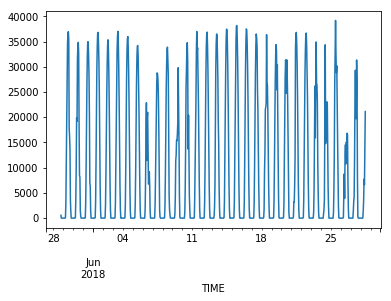

In [24]:
df_solar_hourly['ACTIVEPOWER'].plot()

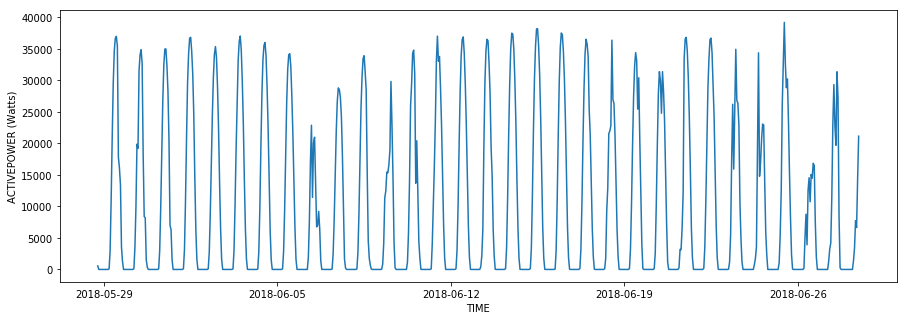

In [25]:
plt.figure(figsize=(15,5))
plt.plot(df_solar_hourly['ACTIVEPOWER'])
plt.ylabel('ACTIVEPOWER (Watts)')
plt.xlabel('TIME')
#plt.legend()
plt.show()

In [26]:
df = df_solar_hourly
df = df.groupby(df.index.hour).mean()
df

,ACTIVEPOWER,IRRADIANCE
TIME,,
0,0.000000,65.730208
1,0.000000,67.734757
2,0.000000,74.731856
3,0.000000,88.847691
4,0.000000,106.562978
5,94.207527,128.818914
6,2448.482527,183.213733
7,8199.739785,272.985971
8,16199.345430,395.532529


In [27]:
df_solar_hourly.between_time('19:00:00','19:00:00')

,ACTIVEPOWER,IRRADIANCE
TIME,,
2018-05-28 19:00:00,0.216667,2.291667
2018-05-29 19:00:00,0.833333,2.266667
2018-05-30 19:00:00,0.000000,1.350000
2018-05-31 19:00:00,0.316667,2.466667
2018-06-01 19:00:00,3.066667,2.550000
2018-06-02 19:00:00,2.533333,238.457414
2018-06-03 19:00:00,20.566667,609.928002
2018-06-04 19:00:00,3.883333,2.966667
2018-06-05 19:00:00,6.850000,2.983333


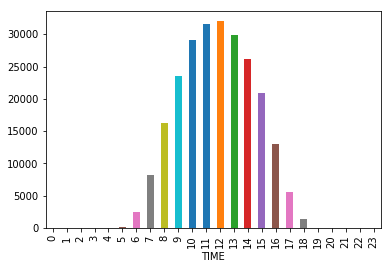

In [28]:
df['ACTIVEPOWER'].plot(kind='bar')

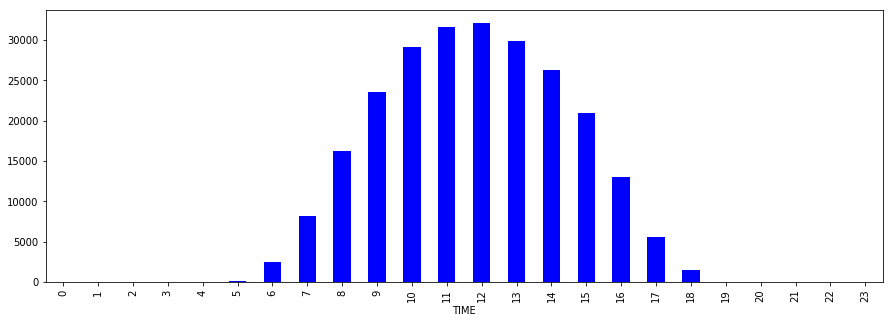

In [29]:
plt.figure(figsize=(15,5))
df['ACTIVEPOWER'].plot.bar(color='b')

In [30]:
df_solar_5 = get_data_for_corresponding_meter('5', start_date, df_irr, end_date, 'Solar_Jaipur.db')
df_solar_5_hourly = resample_minute_to_hour_meter_data(df_solar_5)
df_5 = group_by_hour(df_solar_5_hourly)
df_5

(52729, 5)
(44072, 5)
(44072, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-17 06:07:00'], dtype='datetime64[ns]', name='TIME', freq=None)
1
0
(44071, 1)
(44205, 1)


/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """


,ACTIVEPOWER,IRRADIANCE
TIME,,
0,0.000000,65.730208
1,0.000000,67.734757
2,0.000000,74.731856
3,0.000000,88.847691
4,0.000000,106.562978
5,0.094208,128.818914
6,2.448483,183.213733
7,8.199740,272.985971
8,16.199345,395.532529


In [31]:
meter_ids1 = {'5':'METER 5' , '6':'METER 6', '7':'METER 7', '8':'METER 8', '9':'METER 9', '10':'METER 10', '11':'METER 11'}
meter_ids1

{'5': 'METER 5',
 '6': 'METER 6',
 '7': 'METER 7',
 '8': 'METER 8',
 '9': 'METER 9',
 '10': 'METER 10',
 '11': 'METER 11'}

In [32]:
meter_df_dict1 = read_dataframe_from_database(meter_ids1, start_date, df_irr, end_date, 'Solar_Jaipur.db')

5
(52729, 5)
(44072, 5)
(44072, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-17 06:07:00'], dtype='datetime64[ns]', name='TIME', freq=None)
1
0
(44071, 1)
(44205, 1)
                     ACTIVEPOWER  IRRADIANCE
TIME                                        
2018-05-28 18:00:00     0.562500   22.961538
2018-05-28 19:00:00     0.000217    2.291667
2018-05-28 20:00:00     0.000000    1.000000
2018-05-28 21:00:00     0.000000    1.000000
2018-05-28 22:00:00     0.000000    1.000000
2018-05-28 23:00:00     0.000000    1.000000
2018-05-29 00:00:00     0.000000    1.000000
2018-05-29 01:00:00     0.000000    1.000000
2018-05-29 02:00:00     0.000000    1.000000
2018-05-29 03:00:00     0.000000    1.000000
2018-05-29 04:00:00     0.000000    1.000000
2018-05-29 05:00:00     0.100250    6.650000
2018-05-29 06:00:00     3.004500   72.966667
2018-05-29 07:00:00    11.189817  255.100000
2018-05-29 08:00:00    20.854950  475.408333
2018-05-29 09:00:00    29.446417

/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """


(52729, 5)
(44073, 5)
(44073, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-17 06:07:00', '2018-06-17 07:11:00',
               '2018-06-17 14:21:00', '2018-06-17 14:30:00',
               '2018-06-17 15:47:00', '2018-06-17 18:40:00',
               '2018-06-18 08:28:00', '2018-06-18 09:05:00'],
              dtype='datetime64[ns]', name='TIME', freq=None)
8
0
(44065, 1)
(44205, 1)
                     ACTIVEPOWER  IRRADIANCE
TIME                                        
2018-05-28 18:00:00     0.663885   22.961538
2018-05-28 19:00:00     0.001467    2.291667
2018-05-28 20:00:00     0.000000    1.000000
2018-05-28 21:00:00     0.000000    1.000000
2018-05-28 22:00:00     0.000000    1.000000
2018-05-28 23:00:00     0.000000    1.000000
2018-05-29 00:00:00     0.000000    1.000000
2018-05-29 01:00:00     0.000000    1.000000
2018-05-29 02:00:00     0.000000    1.000000
2018-05-29 03:00:00     0.000000    1.000000
2018-05-29 04:00:00     0.000000    1.0

(52729, 5)
(44071, 5)
(44071, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-05-31 10:32:00', '2018-05-31 11:15:00',
               '2018-05-31 14:59:00', '2018-05-31 15:27:00',
               '2018-05-31 17:52:00', '2018-05-31 19:26:00',
               '2018-05-31 22:44:00', '2018-05-31 23:07:00',
               '2018-06-01 01:43:00', '2018-06-01 02:12:00',
               '2018-06-01 04:15:00', '2018-06-01 04:19:00',
               '2018-06-01 05:20:00', '2018-06-01 05:42:00',
               '2018-06-01 06:39:00', '2018-06-01 10:11:00',
               '2018-06-01 10:32:00', '2018-06-01 10:49:00',
               '2018-06-01 10:51:00', '2018-06-01 10:56:00',
               '2018-06-01 11:06:00', '2018-06-01 11:09:00',
               '2018-06-05 02:41:00', '2018-06-05 05:12:00',
               '2018-06-27 10:02:00', '2018-06-27 11:13:00',
               '2018-06-27 14:26:00', '2018-06-27 20:00:00',
               '2018-06-28 00:06:00', '2018-06-28 10:54:00

(52729, 5)
(44068, 5)
(44068, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-13 21:33:00', '2018-06-13 23:38:00',
               '2018-06-14 00:24:00', '2018-06-14 08:25:00',
               '2018-06-14 08:29:00', '2018-06-14 08:33:00',
               '2018-06-14 08:38:00'],
              dtype='datetime64[ns]', name='TIME', freq=None)
7
0
(44061, 1)
(44205, 1)
                     ACTIVEPOWER  IRRADIANCE
TIME                                        
2018-05-28 18:00:00     0.567154   22.961538
2018-05-28 19:00:00     0.001783    2.291667
2018-05-28 20:00:00     0.000000    1.000000
2018-05-28 21:00:00     0.000000    1.000000
2018-05-28 22:00:00     0.000000    1.000000
2018-05-28 23:00:00     0.000000    1.000000
2018-05-29 00:00:00     0.000000    1.000000
2018-05-29 01:00:00     0.000000    1.000000
2018-05-29 02:00:00     0.000000    1.000000
2018-05-29 03:00:00     0.000000    1.000000
2018-05-29 04:00:00     0.000000    1.000000
2018-05-29 05:00:

In [33]:
meter_id2 = {'16':'METER 16', '24':'METER 24'}

In [34]:
meter_df_dict2 = read_dataframe_from_database(meter_id2, start_date, df_irr, end_date, 'SQF_HT_june.db')

16
(45210, 5)
(44100, 5)
(44100, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex([], dtype='datetime64[ns]', name='TIME', freq=None)
0
0
(44100, 1)
(44205, 1)
                     ACTIVEPOWER  IRRADIANCE
TIME                                        
2018-05-28 18:00:00     0.521577   22.961538
2018-05-28 19:00:00     0.000517    2.291667
2018-05-28 20:00:00     0.000000    1.000000
2018-05-28 21:00:00     0.000000    1.000000
2018-05-28 22:00:00     0.000000    1.000000
2018-05-28 23:00:00     0.000000    1.000000
2018-05-29 00:00:00     0.000000    1.000000
2018-05-29 01:00:00     0.000000    1.000000
2018-05-29 02:00:00     0.000000    1.000000
2018-05-29 03:00:00     0.000000    1.000000
2018-05-29 04:00:00     0.000000    1.000000
2018-05-29 05:00:00     0.138967    6.650000
2018-05-29 06:00:00     3.420800   72.966667
2018-05-29 07:00:00    11.471383  255.100000
2018-05-29 08:00:00    20.661900  475.408333
2018-05-29 09:00:00    28.628317  689.200000
2018-05

/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """


(45212, 5)
(44101, 5)
(44101, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-04 10:32:00', '2018-06-04 10:34:00',
               '2018-06-04 10:37:00', '2018-06-04 10:50:00',
               '2018-06-04 10:59:00', '2018-06-04 11:03:00',
               '2018-06-04 11:06:00', '2018-06-04 11:14:00',
               '2018-06-04 11:29:00', '2018-06-04 11:36:00',
               '2018-06-04 11:43:00', '2018-06-04 17:31:00',
               '2018-06-04 17:37:00', '2018-06-04 18:36:00',
               '2018-06-04 23:42:00', '2018-06-05 01:24:00',
               '2018-06-05 01:30:00', '2018-06-05 01:59:00',
               '2018-06-05 02:02:00', '2018-06-05 02:26:00',
               '2018-06-05 02:29:00', '2018-06-05 02:35:00',
               '2018-06-05 02:44:00', '2018-06-05 02:46:00',
               '2018-06-05 02:53:00', '2018-06-05 02:55:00',
               '2018-06-05 03:01:00', '2018-06-05 03:06:00',
               '2018-06-05 03:21:00', '2018-06-05 03:33:00

In [35]:
meter_df_dict = dict(meter_df_dict1)
meter_df_dict.update(meter_df_dict2)
meter_ids = dict(meter_ids1)
meter_ids.update(meter_id2)

In [36]:
module_info = {'5':198 , '6':220, '7':198, '8':198, '9':220, '10':220, '11':220, '16':198, '24':198}

In [37]:
for meter_id, df in meter_df_dict.items():
    print (df)

      ACTIVEPOWER  IRRADIANCE
TIME                         
0        0.000000   65.730208
1        0.000000   67.734757
2        0.000000   74.731856
3        0.000000   88.847691
4        0.000000  106.562978
5        0.094208  128.818914
6        2.448483  183.213733
7        8.199740  272.985971
8       16.199345  395.532529
9       23.499803  508.188538
10      29.099975  608.489249
11      31.408116  673.885947
12      32.062818  671.793212
13      29.887386  622.588348
14      26.239313  562.526783
15      20.921242  444.826664
16      13.006694  308.956821
17       5.546744  171.945085
18       1.435503   92.865896
19       0.012673   61.947452
20       0.000000   61.424003
21       0.000000   62.500554
22       0.000000   63.577106
23       0.000000   64.653657
      ACTIVEPOWER  IRRADIANCE
TIME                         
0        0.000000   65.730208
1        0.000000   67.734757
2        0.000000   74.731856
3        0.000000   88.847691
4        0.000000  106.562978
5        0

In [38]:
df_all = pd.DataFrame()
for meter_id, df in meter_df_dict.items():
    print (df['ACTIVEPOWER'])
    print (module_info[meter_id])
    df_all[meter_ids[meter_id]] = df['ACTIVEPOWER']/module_info[meter_id]

TIME
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.094208
6      2.448483
7      8.199740
8     16.199345
9     23.499803
10    29.099975
11    31.408116
12    32.062818
13    29.887386
14    26.239313
15    20.921242
16    13.006694
17     5.546744
18     1.435503
19     0.012673
20     0.000000
21     0.000000
22     0.000000
23     0.000000
Name: ACTIVEPOWER, dtype: float64
198
TIME
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.116251
6      2.817372
7      9.191541
8     18.108701
9     26.675017
10    32.998441
11    35.698996
12    36.461429
13    33.952879
14    29.886406
15    23.413297
16    14.526393
17     6.211892
18     1.648186
19     0.017688
20     0.000000
21     0.000000
22     0.000000
23     0.000000
Name: ACTIVEPOWER, dtype: float64
220
TIME
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.104840
6      2.579298
7      8.475755
8     16.6892

In [39]:
df_all

,METER 5,METER 6,METER 7,METER 8,METER 9,METER 10,METER 11,METER 16,METER 24
TIME,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000476,0.000528,0.000529,0.000492,0.000506,0.000461,0.000446,0.000664,0.000683
6,0.012366,0.012806,0.013027,0.012602,0.012475,0.011719,0.011662,0.013534,0.013318
7,0.041413,0.041780,0.042807,0.042895,0.042033,0.038323,0.038075,0.043832,0.043154
8,0.081815,0.082312,0.084289,0.083833,0.082856,0.074844,0.074932,0.083669,0.082434


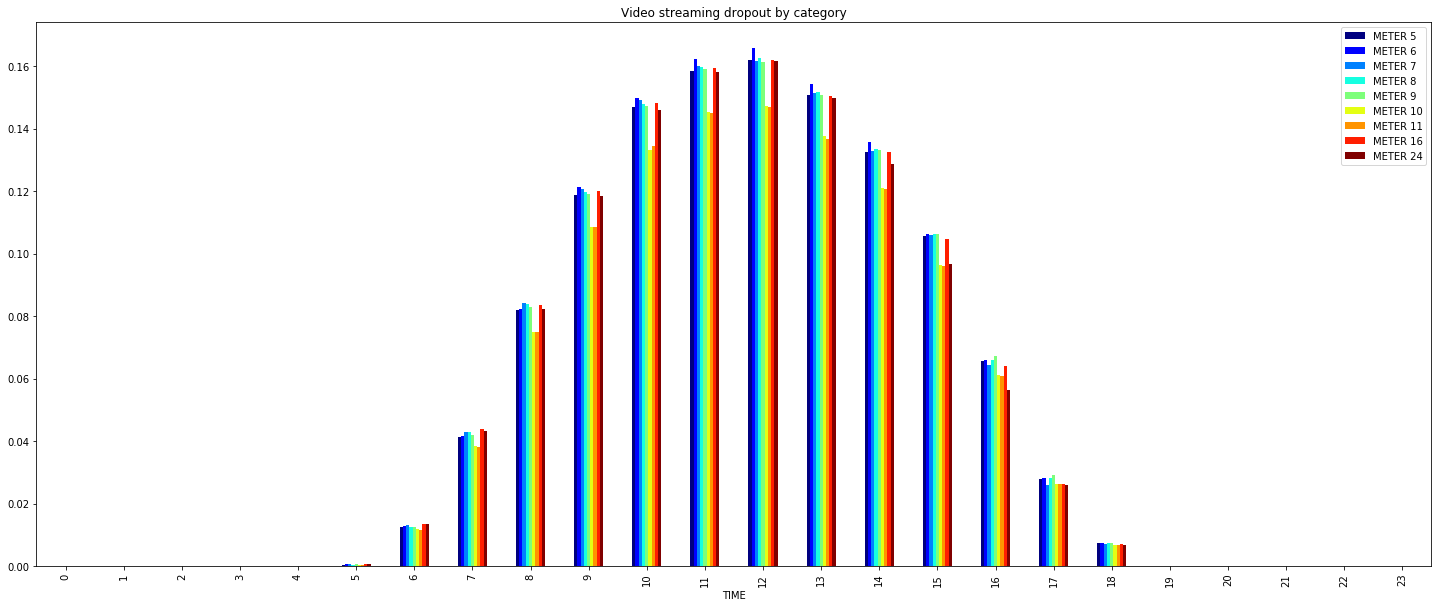

In [40]:
df_all.plot.bar(figsize=(25,10), lw=2, colormap='jet', title='Video streaming dropout by category')

<Figure size 2880x2880 with 0 Axes>

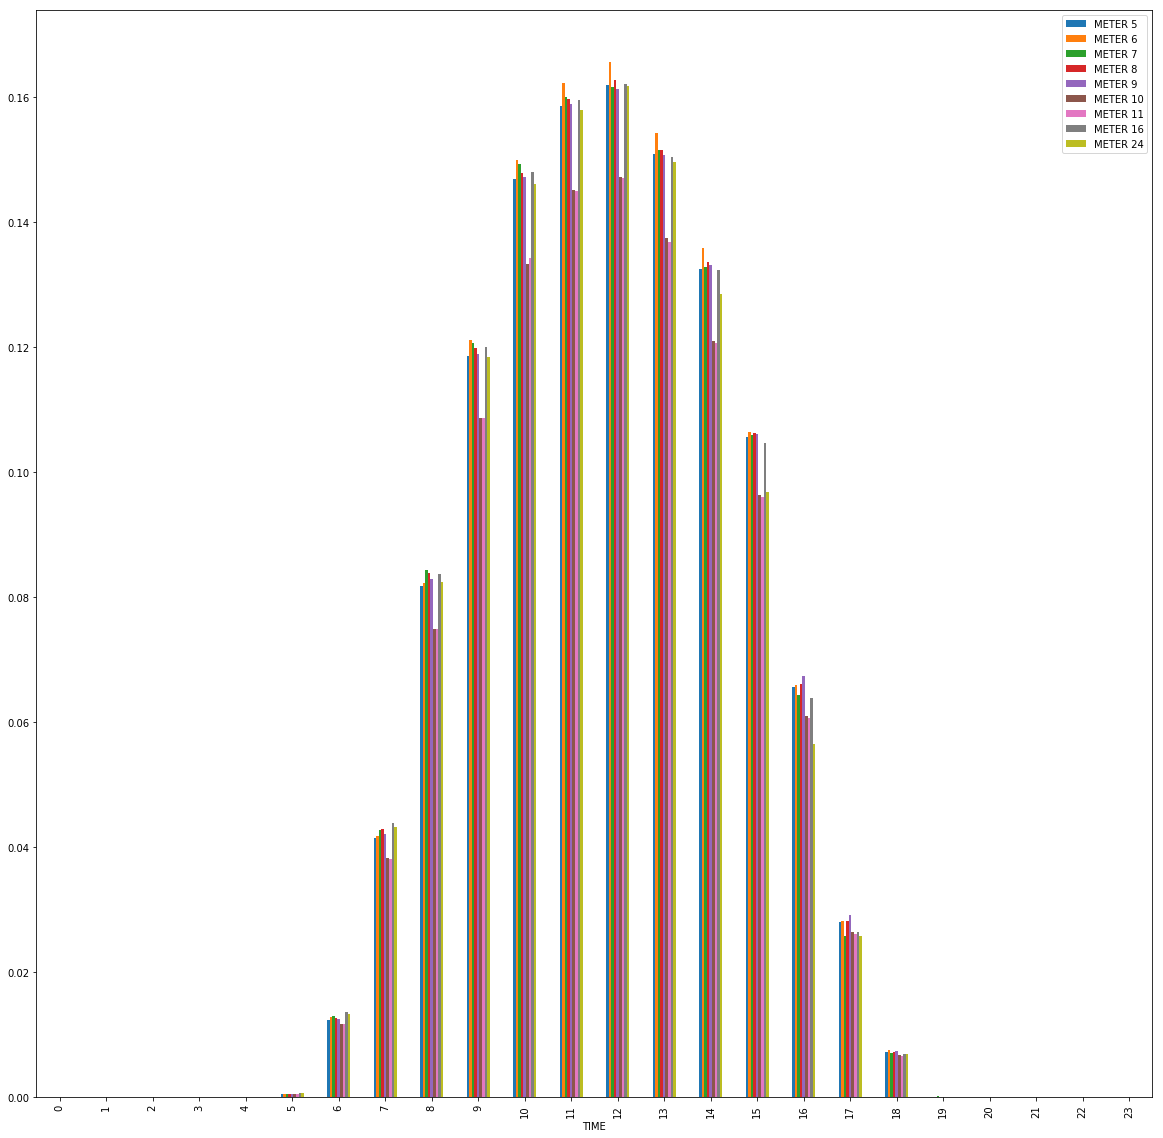

In [41]:
plt.figure(figsize=(40,40))
df_all.plot.bar(figsize=(20,20))

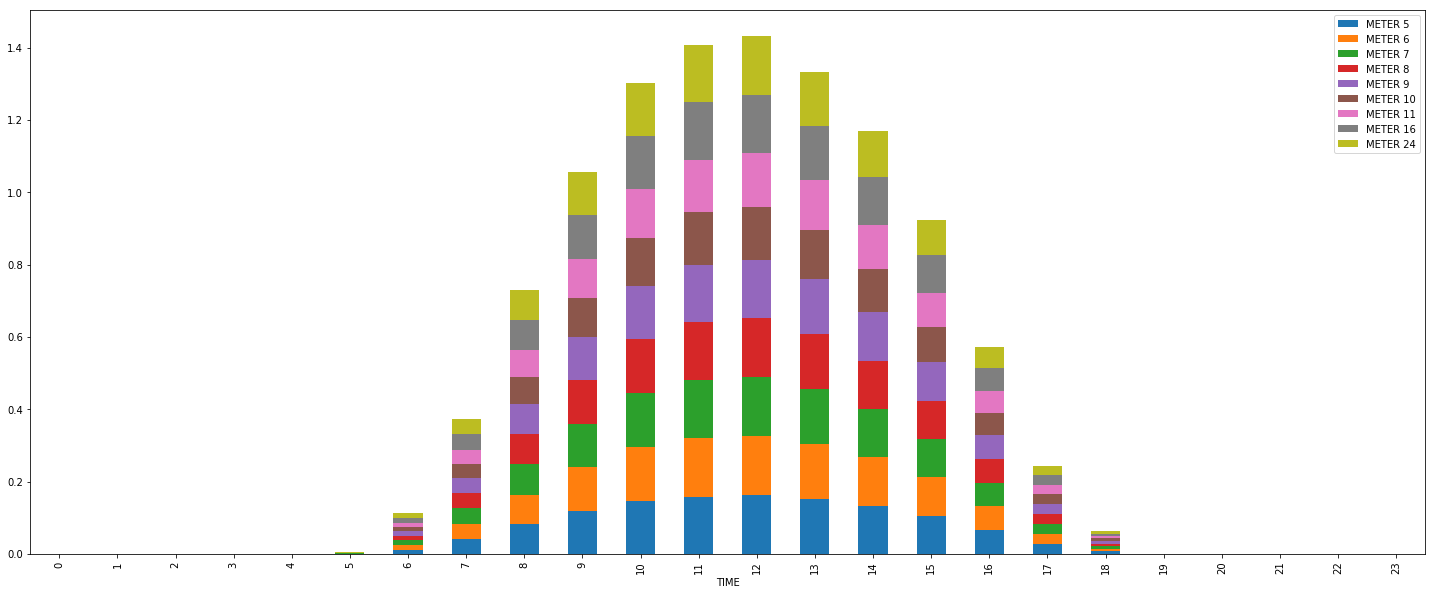

In [42]:
df_all.plot.bar(stacked=True, figsize=(25,10))

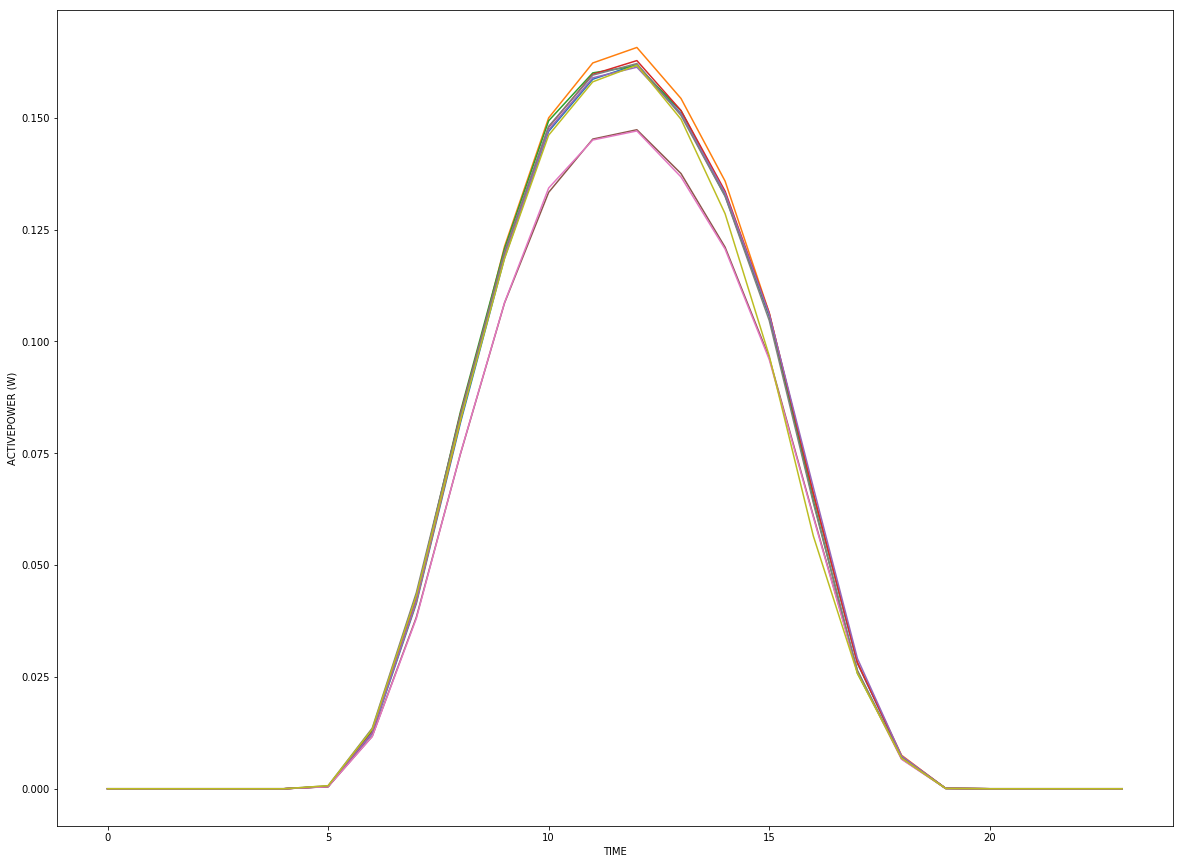

In [43]:
plt.figure(figsize=(20,15))
plt.plot(df_all)
plt.ylabel('ACTIVEPOWER (W)')
plt.xlabel('TIME')
#plt.legend()
plt.show()

In [44]:
df_all = df_all.iloc[5:20,:]
df_all

,METER 5,METER 6,METER 7,METER 8,METER 9,METER 10,METER 11,METER 16,METER 24
TIME,,,,,,,,,
5,0.000476,0.000528,0.000529,0.000492,0.000506,0.000461,0.000446,0.000664,0.000683
6,0.012366,0.012806,0.013027,0.012602,0.012475,0.011719,0.011662,0.013534,0.013318
7,0.041413,0.041780,0.042807,0.042895,0.042033,0.038323,0.038075,0.043832,0.043154
8,0.081815,0.082312,0.084289,0.083833,0.082856,0.074844,0.074932,0.083669,0.082434
9,0.118686,0.121250,0.120765,0.119863,0.119005,0.108615,0.108687,0.120060,0.118522
10,0.146970,0.149993,0.149345,0.147946,0.147324,0.133344,0.134309,0.148091,0.146129
11,0.158627,0.162268,0.160051,0.159732,0.158961,0.145251,0.145042,0.159549,0.158051
12,0.161933,0.165734,0.161663,0.162797,0.161317,0.147338,0.147068,0.162131,0.161772
13,0.150946,0.154331,0.151590,0.151636,0.150847,0.137548,0.136787,0.150522,0.149694


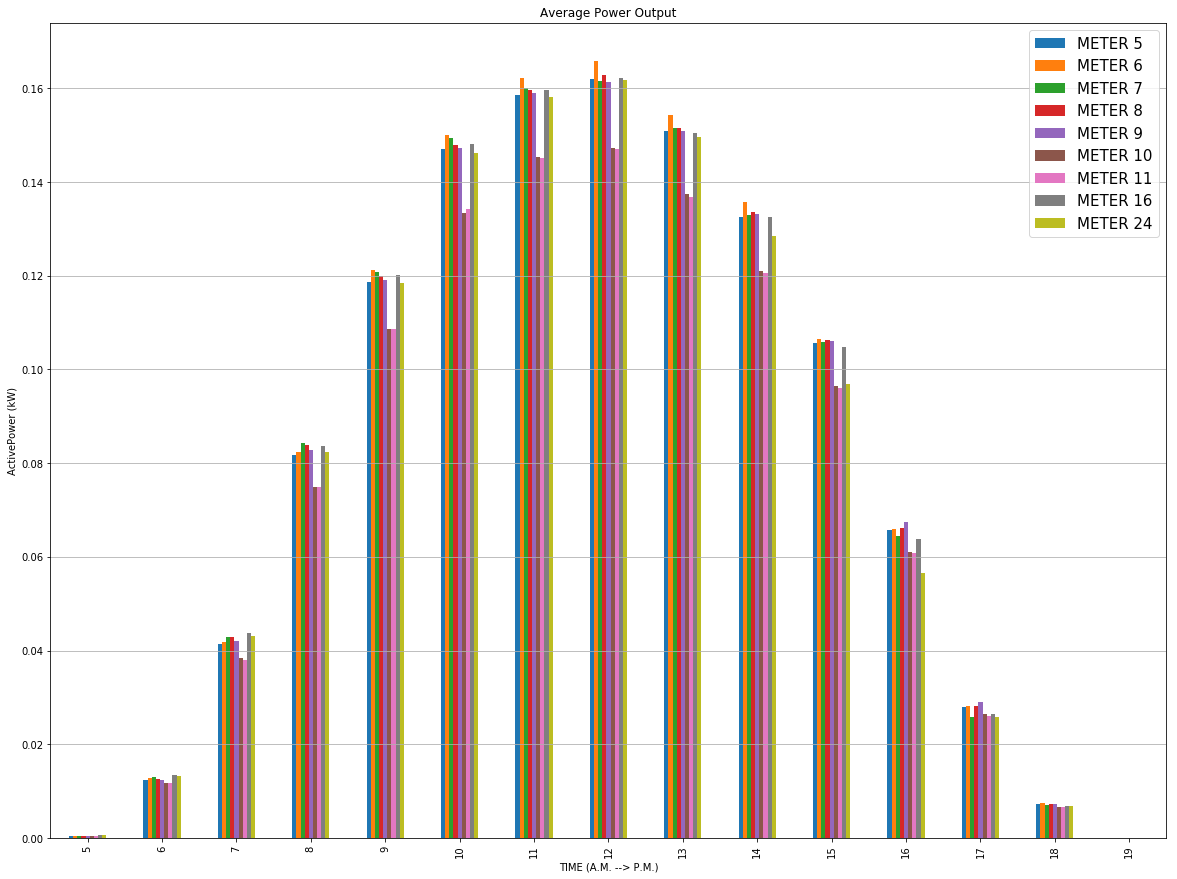

In [45]:
ax = df_all.plot.bar(figsize=(20,15), title='Average Power Output')
#start, end = ax.get_ylim()
#ax.yaxis.set_ticks(np.arange(start, end, 2.5))
ax.set_xlabel("TIME (A.M. --> P.M.)")
ax.set_ylabel("ActivePower (kW)")
ax.yaxis.grid(True)
#ax.grid(zorder=0)
ax.legend(loc='best', fontsize=15)

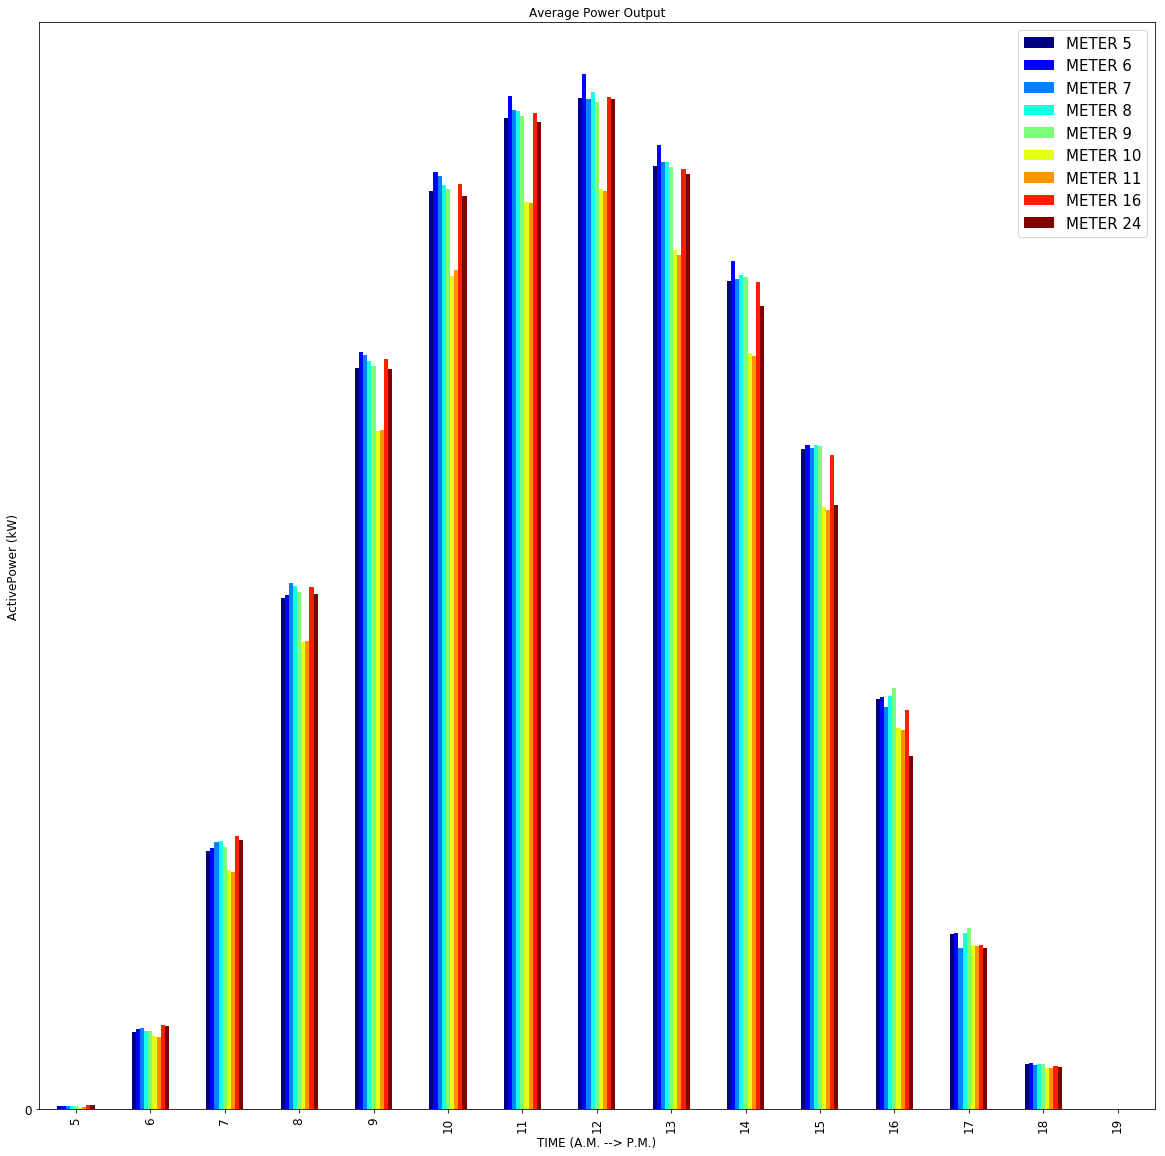

In [46]:
ax = df_all.plot.bar(figsize=(20,20), title='Average Power Output', fontsize='large', colormap='jet')
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 2.5))
ax.set_xlabel("TIME (A.M. --> P.M.)", fontsize='large')
ax.set_ylabel("ActivePower (kW)", fontsize='large')
ax.yaxis.grid(True)
#ax.grid(zorder=0)
ax.legend(loc='best', fontsize=15)

In [47]:
df_solar = get_data_for_corresponding_meter('5', start_date, df_irr, end_date, 'Solar_Jaipur.db')
df_solar

(52729, 5)
(44072, 5)
(44072, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-17 06:07:00'], dtype='datetime64[ns]', name='TIME', freq=None)
1
0
(44071, 1)
(44205, 1)


/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """


,ACTIVEPOWER,IRRADIANCE
TIME,,
2018-05-28 18:34:00,1.116,36.0
2018-05-28 18:35:00,1.059,35.0
2018-05-28 18:36:00,1.018,34.0
2018-05-28 18:37:00,0.969,33.0
2018-05-28 18:38:00,0.930,32.0
2018-05-28 18:39:00,0.885,31.0
2018-05-28 18:40:00,0.837,30.0
2018-05-28 18:41:00,0.798,29.0
2018-05-28 18:42:00,0.747,28.0


In [48]:
df_max_min = df_solar.resample('H')['ACTIVEPOWER'].agg(['min', 'max'])
df_max_min

,min,max
TIME,,
2018-05-28 18:00:00,0.056000,1.116000
2018-05-28 19:00:00,0.000000,0.013000
2018-05-28 20:00:00,0.000000,0.000000
2018-05-28 21:00:00,0.000000,0.000000
2018-05-28 22:00:00,0.000000,0.000000
2018-05-28 23:00:00,0.000000,0.000000
2018-05-29 00:00:00,0.000000,0.000000
2018-05-29 01:00:00,0.000000,0.000000
2018-05-29 02:00:00,0.000000,0.000000


In [49]:
df_hour_max_min = pd.DataFrame()
#df_hour_max_min['MAX'] = df_max_min.groupby(df_max_min.index.hour).max()["max"]
df_hour_max_min['MAX'] = df_max_min['max'].groupby(df_max_min.index.hour).mean()

#df_hour_max_min['MIN'] = df_max_min.groupby(df_max_min.index.hour).min()["min"]
df_hour_max_min['MIN'] = df_max_min['min'].groupby(df_max_min.index.hour).mean()

df_hour_max_min

,MAX,MIN
TIME,,
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
5,0.626548,0.000000
6,4.662581,0.615129
7,12.655065,4.298903
8,21.265742,11.246742


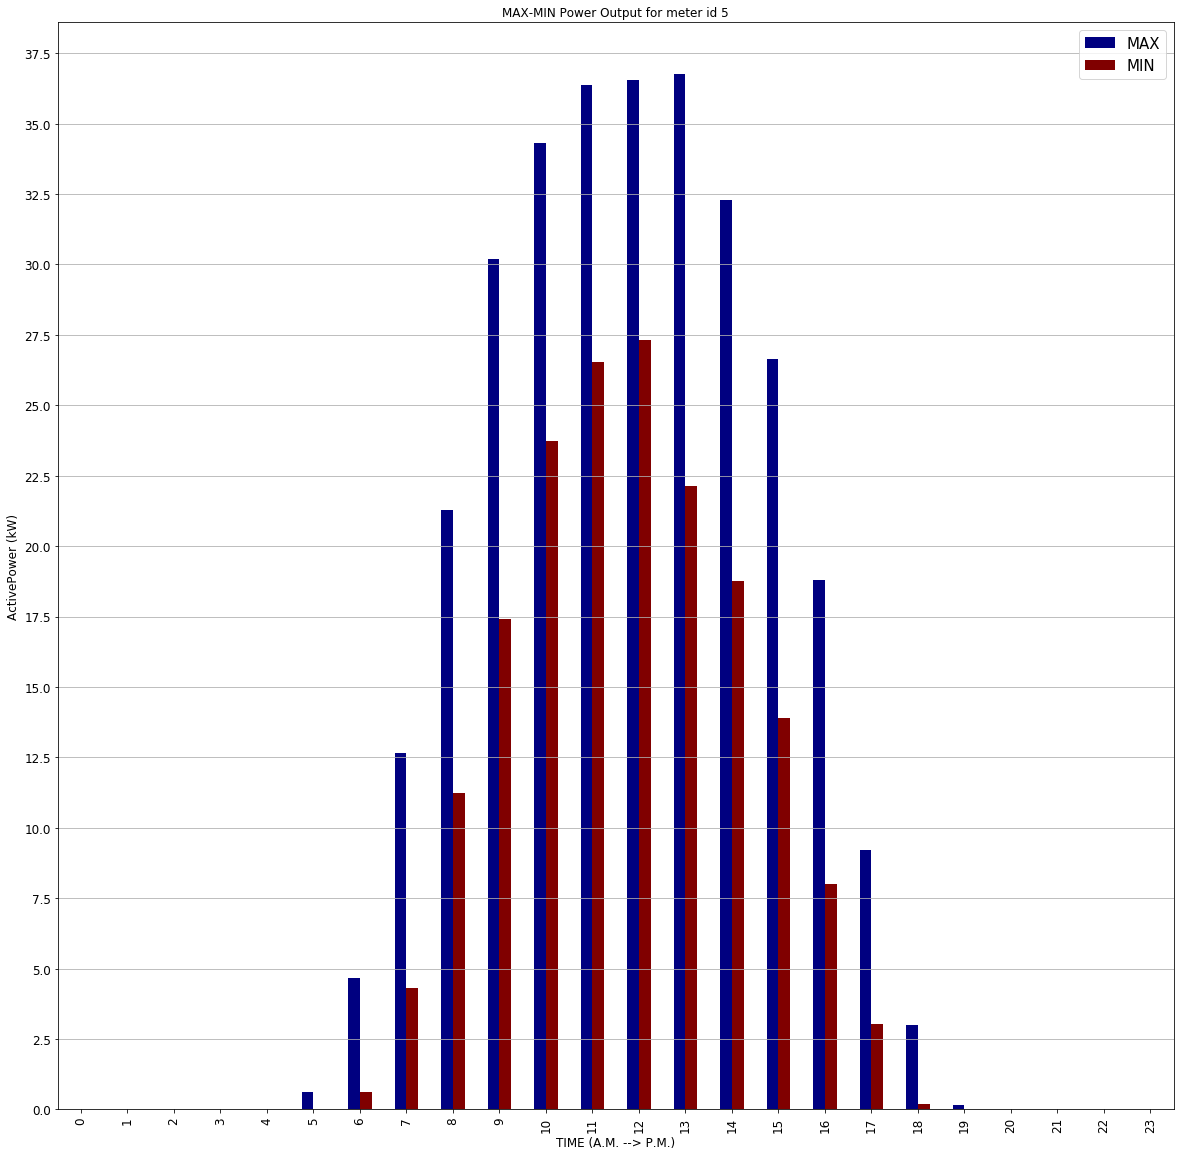

In [50]:
ax = df_hour_max_min.plot.bar(figsize=(20,20), title='MAX-MIN Power Output for meter id ' + '5', fontsize='large', colormap='jet')
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 2.5))
ax.set_xlabel("TIME (A.M. --> P.M.)", fontsize='large')
ax.set_ylabel("ActivePower (kW)", fontsize='large')
ax.yaxis.grid(True)
#ax.grid(zorder=0)
ax.legend(loc='best', fontsize=15)

In [51]:
#df_max_min.between_time('07:00:00','07:00:00')

In [52]:
meter_hour_max_min_df_dict1 = get_max_min_ACTIVEPOWER_hourly(meter_ids1, start_date, df_irr, end_date, 'Solar_Jaipur.db')
meter_hour_max_min_df_dict2 = get_max_min_ACTIVEPOWER_hourly(meter_id2, start_date, df_irr, end_date, 'SQF_HT_june.db')
meter_hour_max_min_df_dict = dict(meter_hour_max_min_df_dict1)
meter_hour_max_min_df_dict.update(meter_hour_max_min_df_dict2)
for meter_id, df in meter_hour_max_min_df_dict.items():
    print (meter_id)
    print (df)

5
(52729, 5)
(44072, 5)
(44072, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-17 06:07:00'], dtype='datetime64[ns]', name='TIME', freq=None)
1
0
(44071, 1)
(44205, 1)
6


/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """


(52729, 5)
(44073, 5)
(44073, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-17 06:07:00', '2018-06-17 07:11:00',
               '2018-06-17 14:21:00', '2018-06-17 14:30:00',
               '2018-06-17 15:47:00', '2018-06-17 18:40:00',
               '2018-06-18 08:28:00', '2018-06-18 09:05:00'],
              dtype='datetime64[ns]', name='TIME', freq=None)
8
0
(44065, 1)
(44205, 1)
7
(52729, 5)
(44071, 5)
(44071, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-05-31 16:55:00', '2018-06-01 04:02:00',
               '2018-06-01 04:06:00', '2018-06-01 04:14:00',
               '2018-06-01 10:30:00', '2018-06-16 18:56:00',
               '2018-06-16 18:59:00', '2018-06-16 20:47:00',
               '2018-06-16 23:13:00', '2018-06-17 01:06:00',
               '2018-06-17 01:23:00', '2018-06-17 01:25:00',
               '2018-06-17 03:49:00', '2018-06-17 05:35:00',
               '2018-06-17 05:54:00', '2018-06-17 05:57:00',
 

      MAX ACTIVEPOWER  MIN ACTIVEPOWER
TIME                                  
0            0.000000         0.000000
1            0.000000         0.000000
2            0.000000         0.000000
3            0.000000         0.000000
4            0.000000         0.000000
5            0.003859         0.000000
6            0.025271         0.003736
7            0.065741         0.023625
8            0.107620         0.057821
9            0.153667         0.076884
10           0.174964         0.109492
11           0.183247         0.129941
12           0.186010         0.135501
13           0.185628         0.109959
14           0.162814         0.089307
15           0.126169         0.062569
16           0.082357         0.036255
17           0.041409         0.014444
18           0.014241         0.000910
19           0.000802         0.000000
20           0.000000         0.000000
21           0.000000         0.000000
22           0.000000         0.000000
23           0.000000    

In [53]:
'''
def show_plot_max_min_meters(meter_hour_max_min_df_dict):
    for meter_id, df in meter_hour_max_min_df_dict.items():
        #fig, ax = plt.subplots()
        ax = df.plot.bar(figsize=(20,20), title='MAX-MIN Power Output for meter id ' + meter_id, fontsize='large', colormap='jet')
        start, end = ax.get_ylim()
        print (start)
        print (end)
        ax.yaxis.set_ticks(np.arange(start, end, 2.5))
        ax.set_xlabel("TIME (A.M. --> P.M.)", fontsize='large')
        ax.set_ylabel("ActivePower (kW)", fontsize='large')
        ax.yaxis.grid(True)
        #ax.grid(zorder=0)
        ax.legend(loc='best', fontsize=15)
'''

'\ndef show_plot_max_min_meters(meter_hour_max_min_df_dict):\n    for meter_id, df in meter_hour_max_min_df_dict.items():\n        #fig, ax = plt.subplots()\n        ax = df.plot.bar(figsize=(20,20), title=\'MAX-MIN Power Output for meter id \' + meter_id, fontsize=\'large\', colormap=\'jet\')\n        start, end = ax.get_ylim()\n        print (start)\n        print (end)\n        ax.yaxis.set_ticks(np.arange(start, end, 2.5))\n        ax.set_xlabel("TIME (A.M. --> P.M.)", fontsize=\'large\')\n        ax.set_ylabel("ActivePower (kW)", fontsize=\'large\')\n        ax.yaxis.grid(True)\n        #ax.grid(zorder=0)\n        ax.legend(loc=\'best\', fontsize=15)\n'

In [54]:
from matplotlib.lines import Line2D
from datetime import timedelta

In [55]:
def show_plot_max_min_meters(meter_hour_max_min_df_dict):
    rand_width = -0.32
    count = 0
    colouring = ['red', 'blue', 'brown', 'green', 'cyan', 'black', 'gold', 'grey', 'indigo']
    fig, ax = plt.subplots(figsize=(20,20))
    for meter_id, df in meter_hour_max_min_df_dict.items():
        
        #print (meter_id)
        #print ()
        
        df = df.iloc[5:20,:]
        
        px = df.index.tolist()
        
        px[:] = [x + rand_width for x in px]
        #print (px)
        #print ()
        py = df['MIN ACTIVEPOWER'].tolist()
        pz = df['MAX ACTIVEPOWER'].tolist()
        ax.vlines(px, py, pz, color = colouring[count])
        rand_width += 0.08
        count += 1
        #print (px)
        #print (py)
        #print (pz)
        
        #print ()
        #print  ()
        
    start, end = plt.ylim()
    #print (start)
    #print (end)
    ax.yaxis.set_ticks(np.arange(start, end, 0.0025))
    ax.set_xlabel("TIME (A.M. --> P.M.)", fontsize='large')
    ax.set_ylabel("ActivePower (kW)", fontsize='large')
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.xaxis.set_ticks(np.arange(5, 20, 1))
    legend_elements = [Line2D([0], [0], color=colouring[0], lw=4, label='meter 5'),
                       Line2D([0], [0], color=colouring[1], lw=4, label='meter 6'),
                       Line2D([0], [0], color=colouring[2], lw=4, label='meter 7'),
                       Line2D([0], [0], color=colouring[3], lw=4, label='meter 8'),
                       Line2D([0], [0], color=colouring[4], lw=4, label='meter 9'),
                       Line2D([0], [0], color=colouring[5], lw=4, label='meter 10'),
                       Line2D([0], [0], color=colouring[6], lw=4, label='meter 11'),
                       Line2D([0], [0], color=colouring[7], lw=4, label='meter 16'),
                       Line2D([0], [0], color=colouring[8], lw=4, label='meter 24')]
                       

    ax.legend(handles=legend_elements, loc='best',  fontsize=15)
    
    plt.show()
        

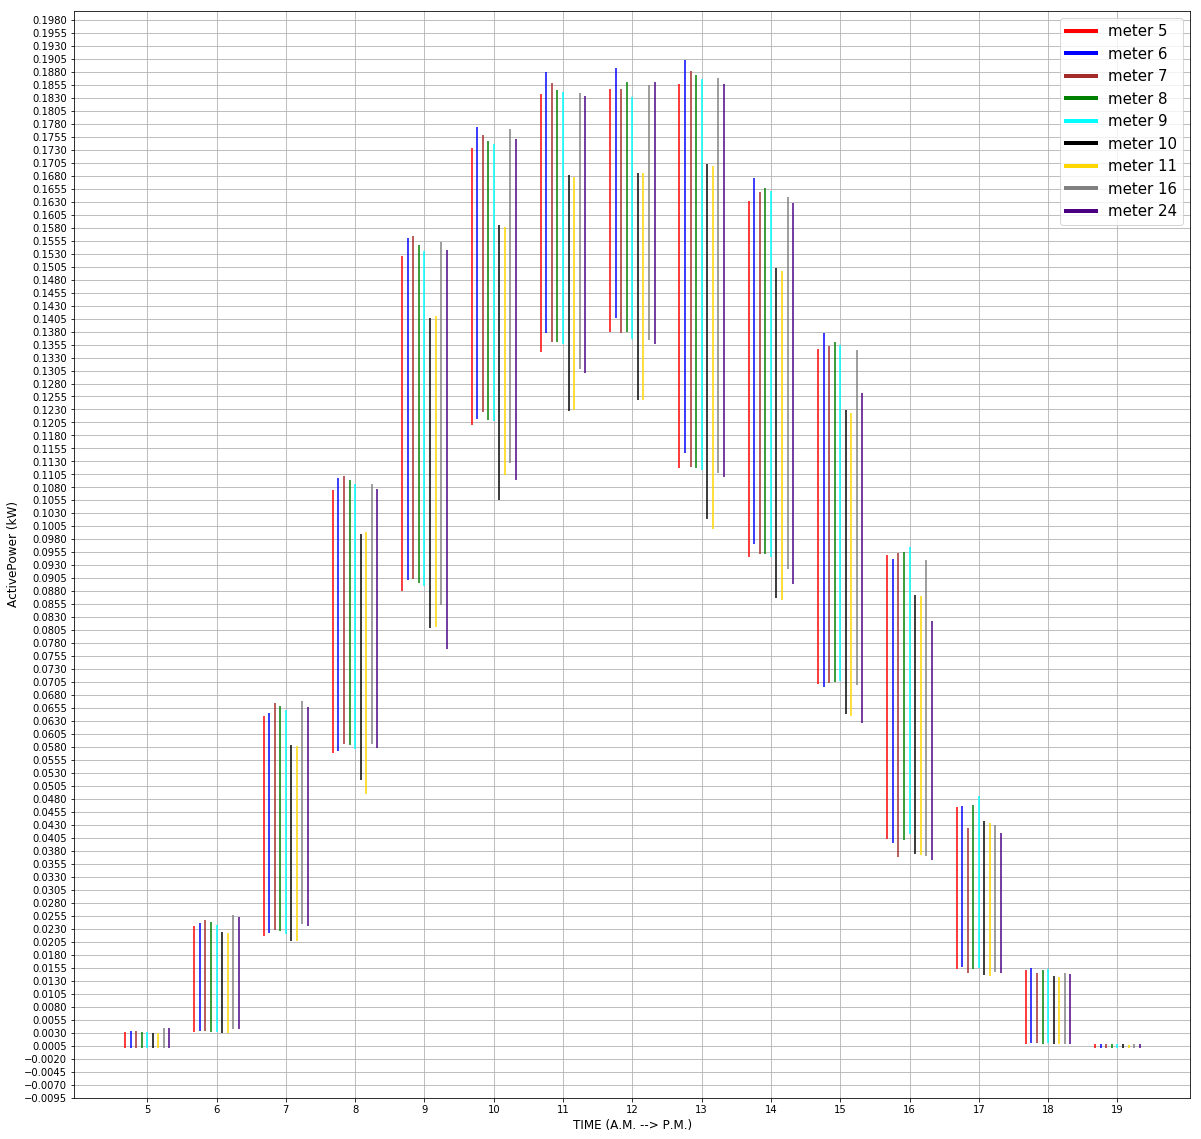

In [56]:
show_plot_max_min_meters(meter_hour_max_min_df_dict)

# Weather starts here..................

start_date_weather = '2018-05-28 18:00:00'
end_date_weather = '2018-06-28 12:00:00'
weather_database = '/home/bosch/simran/weather_processed_corrected.xlsx'
df_weather = pd.read_excel(weather_database, sheet_name='Sheet1', usecols =[1, 2, 6, 7, 8])
df_weather.columns = ['TIME', 'TEMPERATURE', 'WEATHER_ID', 'WEATHER_MAJOR', 'WEATHER_MINOR']
df_weather['TIME'] = df_weather['TIME'] - timedelta(hours=0, minutes=30)
df_weather = df_weather[df_weather['TIME'] >= start_date_weather]
df_weather = df_weather[df_weather['TIME'] < end_date_weather]
df_weather

df_weather.groupby(df_weather['WEATHER_ID']).count()

In [57]:
def get_weather_data(start_date_weather, end_date_weather, weather_database):
    df_weather = pd.read_excel(weather_database, sheet_name='Sheet1', usecols =[1, 2, 6, 7, 8])
    df_weather.columns = ['TIME', 'TEMPERATURE', 'WEATHER_ID', 'WEATHER_MAJOR', 'WEATHER_MINOR']
    df_weather['TIME'] = df_weather['TIME'] - timedelta(hours=0, minutes=30)
    df_weather = df_weather[df_weather['TIME'] >= start_date_weather]
    df_weather = df_weather[df_weather['TIME'] < end_date_weather]
    #df_weather['WEATHER_MAJOR'] = map(lambda x: str(x).upper(), df_weather['WEATHER_MAJOR'])
    df_weather['WEATHER_MAJOR'] = df_weather['WEATHER_MAJOR'].str.upper()
    #df_weather['WEATHER_MINOR'] = map(lambda x: str(x).upper(), df_weather['WEATHER_MINOR'])
    df_weather['WEATHER_MINOR'] = df_weather['WEATHER_MINOR'].str.upper()
    #df['1/2 ID'].str.upper()
    return df_weather

In [58]:
start_date_weather = '2018-05-28 18:00:00'
end_date_weather = '2018-06-28 12:00:00'
weather_database = '/home/bosch/simran/weather_processed_corrected.xlsx'
df_weather = get_weather_data(start_date_weather, end_date_weather, weather_database)
df_weather

,TIME,TEMPERATURE,WEATHER_ID,WEATHER_MAJOR,WEATHER_MINOR
40964,2018-05-28 18:00:00,315.211,800,CLEAR,SKY IS CLEAR
40965,2018-05-28 19:00:00,304.849,800,CLEAR,SKY IS CLEAR
40966,2018-05-28 20:00:00,304.849,800,CLEAR,SKY IS CLEAR
40967,2018-05-28 21:00:00,304.849,800,CLEAR,SKY IS CLEAR
40968,2018-05-28 22:00:00,300.044,800,CLEAR,SKY IS CLEAR
40969,2018-05-28 23:00:00,308.150,721,HAZE,HAZE
40970,2018-05-29 00:00:00,309.150,721,HAZE,HAZE
40971,2018-05-29 01:00:00,308.150,721,HAZE,HAZE
40972,2018-05-29 02:00:00,309.150,721,HAZE,HAZE
40973,2018-05-29 03:00:00,309.150,721,HAZE,HAZE


In [59]:
#df_weather_count = df_weather.groupby(['WEATHER_MAJOR' ,'WEATHER_MINOR']).count()
df_weather_count = df_weather.groupby(['WEATHER_ID']).count()
df_weather_count

,TIME,TEMPERATURE,WEATHER_MAJOR,WEATHER_MINOR
WEATHER_ID,,,,
211,6,6,6,6
500,12,12,12,12
701,1,1,1,1
711,1,1,1,1
721,505,505,505,505
761,198,198,198,198
800,9,9,9,9
801,4,4,4,4
802,1,1,1,1


In [60]:
df_weather_count = df_weather_count.reindex([761, 802, 800, 804, 211, 701, 721, 711, 500, 801])

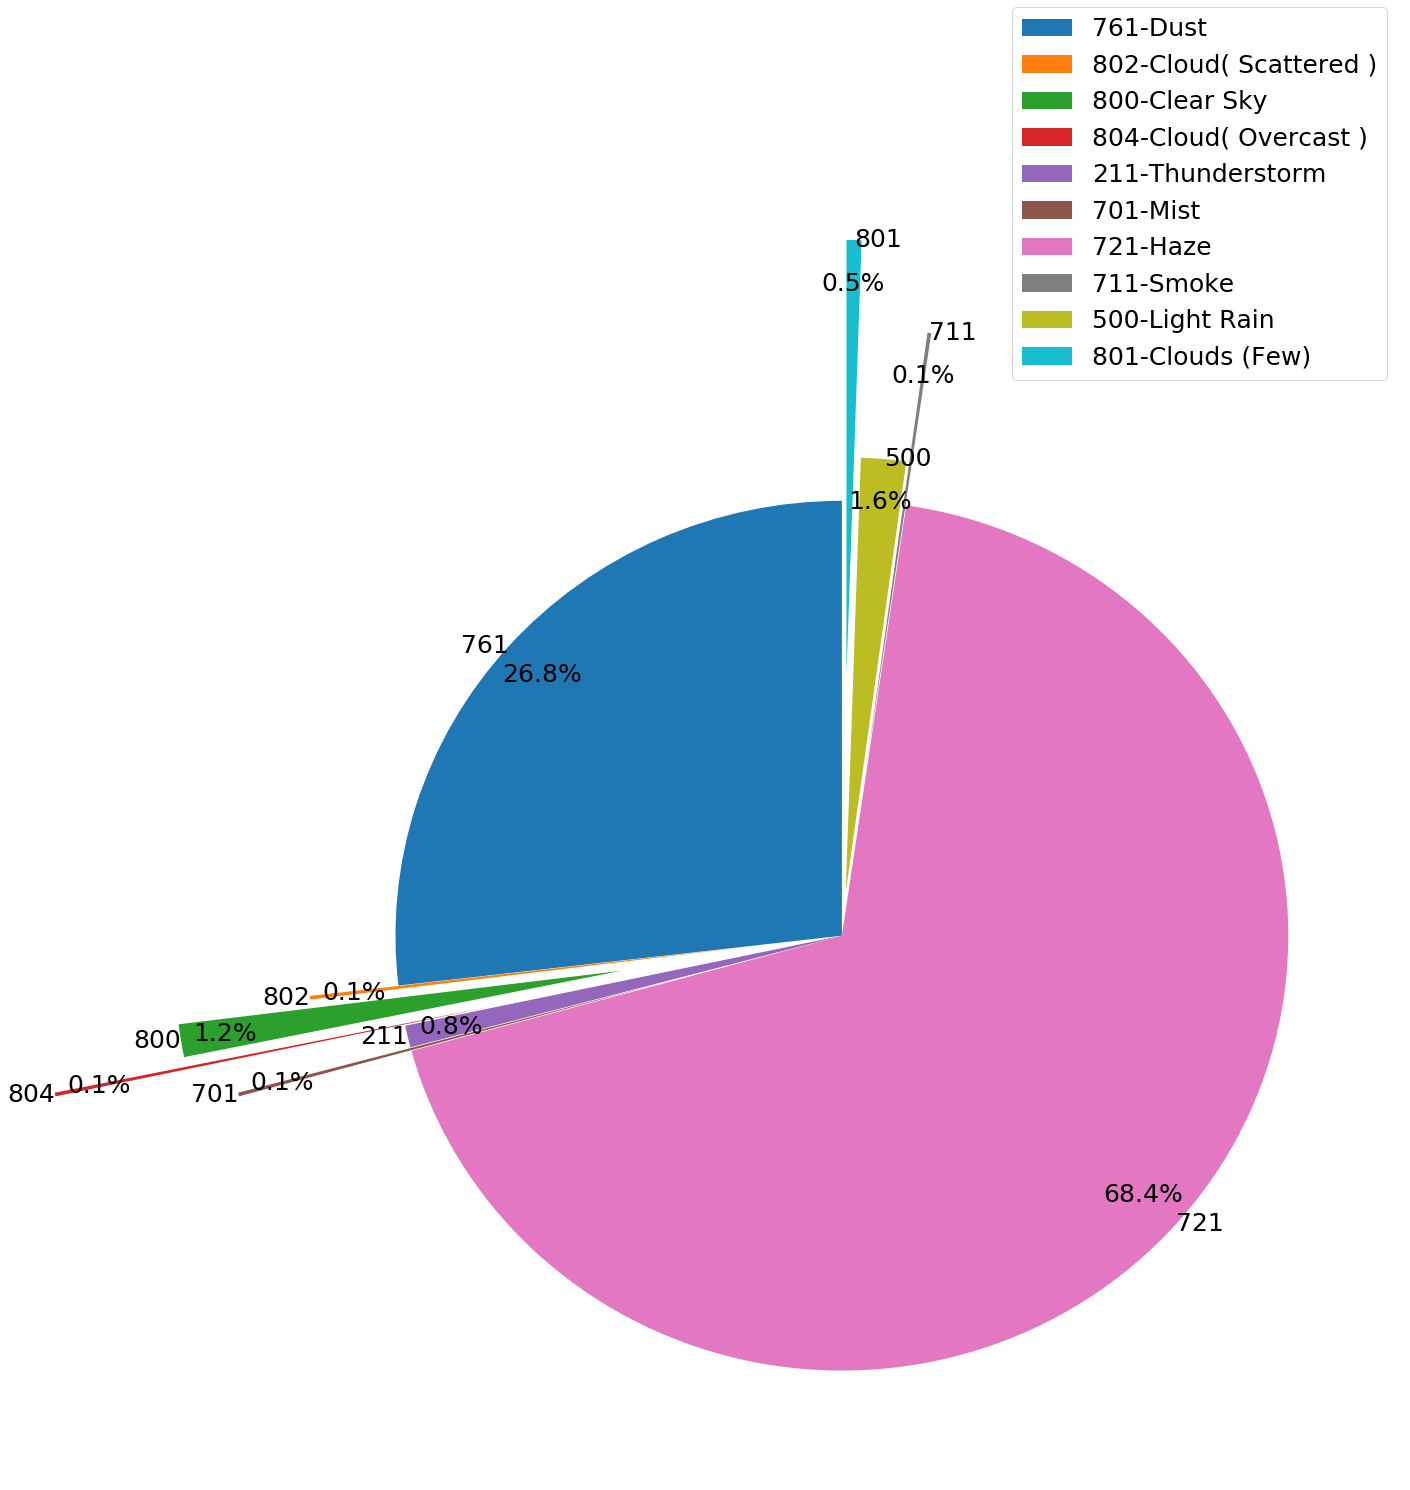

In [76]:
labels = df_weather_count.index
values =  df_weather_count['WEATHER_MAJOR']
explode = (0, 0.2, 0.5, 0.8, 0, 0.4, 0, 0.4, 0.1, 0.6)

fig1, ax1 = plt.subplots(figsize=(20,20))

ax1.pie(values, labels=labels, shadow=False, autopct='%1.1f%%', explode=explode, startangle=90, labeldistance=1,
       pctdistance = 0.9, textprops={'fontsize': 25})

label1 = ['761-Dust', '802-Cloud( Scattered )', '800-Clear Sky', '804-Cloud( Overcast )', '211-Thunderstorm', '701-Mist',
           '721-Haze', '711-Smoke', '500-Light Rain', '801-Clouds (Few)']
plt.legend(label1, loc="lower right", bbox_to_anchor = (1,1), fontsize=25)
#draw circle
#centre_circle = plt.Circle((0,0),0.60,fc='white')
#fig = plt.gcf()
#fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
#plt.tight_layout()
plt.show()

In [62]:
def get_data_of_meter_for_weather(meter_ids, start_date, df_irr, end_date, database):
    
    meter_df_dict = dict()
    for meter_id, name in meter_ids.items():
        print (meter_id)
        df_solar = get_data_for_corresponding_meter(meter_id, start_date, df_irr, end_date, database)
        df_solar_hourly = resample_minute_to_hour_meter_data(df_solar)
        meter_df_dict[meter_id]= df_solar_hourly

    return meter_df_dict

In [63]:
def concatenate_weather_and_meter_data(df_weather, start_date, df_irr, end_date):
    meter_ids1 = {'5':'METER 5' , '6':'METER 6', '7':'METER 7', '8':'METER 8', '9':'METER 9', '10':'METER 10', '11':'METER 11'}
    print (meter_ids1)
    meter_df_dict1 = get_data_of_meter_for_weather(meter_ids1, start_date, df_irr, end_date, 'Solar_Jaipur.db')
    meter_id2 = {'16':'METER 16', '24':'METER 24'}
    meter_df_dict2 = get_data_of_meter_for_weather(meter_id2, start_date, df_irr, end_date, 'SQF_HT_june.db')
    meter_df_dict = dict(meter_df_dict1)
    meter_df_dict.update(meter_df_dict2)
    ###
    meter_ids = dict(meter_ids1)
    meter_ids.update(meter_id2)
    ###
    module_info = {'5':198 , '6':220, '7':198, '8':198, '9':220, '10':220, '11':220, '16':198, '24':198}
    ##
    for meter_id, df in meter_df_dict.items():
        print (df)
    
    df_weather = set_time_as_index(df_weather)
    
    for meter_id, df in meter_df_dict.items():
        print (df['ACTIVEPOWER'])
        print (module_info[meter_id])
        df_weather[meter_ids[meter_id]] = df['ACTIVEPOWER']/module_info[meter_id]
    return df_weather

In [64]:
df_weather = concatenate_weather_and_meter_data(df_weather, start_date, df_irr, end_date)


{'5': 'METER 5', '6': 'METER 6', '7': 'METER 7', '8': 'METER 8', '9': 'METER 9', '10': 'METER 10', '11': 'METER 11'}
5
(52729, 5)
(44072, 5)
(44072, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-17 06:07:00'], dtype='datetime64[ns]', name='TIME', freq=None)
1
0
(44071, 1)
(44205, 1)
6


/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """


(52729, 5)
(44073, 5)
(44073, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-17 06:07:00', '2018-06-17 07:11:00',
               '2018-06-17 14:21:00', '2018-06-17 14:30:00',
               '2018-06-17 15:47:00', '2018-06-17 18:40:00',
               '2018-06-18 08:28:00', '2018-06-18 09:05:00'],
              dtype='datetime64[ns]', name='TIME', freq=None)
8
0
(44065, 1)
(44205, 1)
7
(52729, 5)
(44071, 5)
(44071, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-05-31 16:55:00', '2018-06-01 04:02:00',
               '2018-06-01 04:06:00', '2018-06-01 04:14:00',
               '2018-06-01 10:30:00', '2018-06-16 18:56:00',
               '2018-06-16 18:59:00', '2018-06-16 20:47:00',
               '2018-06-16 23:13:00', '2018-06-17 01:06:00',
               '2018-06-17 01:23:00', '2018-06-17 01:25:00',
               '2018-06-17 03:49:00', '2018-06-17 05:35:00',
               '2018-06-17 05:54:00', '2018-06-17 05:57:00',
 

In [65]:
df_weather

,TEMPERATURE,WEATHER_ID,WEATHER_MAJOR,WEATHER_MINOR,METER 5,METER 6,METER 7,METER 8,METER 9,METER 10,METER 11,METER 16,METER 24
TIME,,,,,,,,,,,,,
2018-05-28 18:00:00,315.211,800,CLEAR,SKY IS CLEAR,0.002841,0.003018,0.002768,0.002858,0.002957,0.002667,0.002578,0.002634,0.002620
2018-05-28 19:00:00,304.849,800,CLEAR,SKY IS CLEAR,0.000001,0.000007,0.000026,0.000015,0.000014,0.000013,0.000008,0.000003,0.000005
2018-05-28 20:00:00,304.849,800,CLEAR,SKY IS CLEAR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-05-28 21:00:00,304.849,800,CLEAR,SKY IS CLEAR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-05-28 22:00:00,300.044,800,CLEAR,SKY IS CLEAR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-05-28 23:00:00,308.150,721,HAZE,HAZE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-05-29 00:00:00,309.150,721,HAZE,HAZE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-05-29 01:00:00,308.150,721,HAZE,HAZE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-05-29 02:00:00,309.150,721,HAZE,HAZE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [66]:
all_weather_ids =  df_weather.WEATHER_ID.unique()
all_weather_ids

array([800, 721, 211, 801, 761, 804, 500, 711, 802, 701])

In [67]:
weather_dict = dict()
for i in range(len(all_weather_ids)):
    weather_dict[all_weather_ids[i]] = df_weather[df_weather['WEATHER_ID'] == all_weather_ids[i]]

In [68]:
weather_dict[800]

,TEMPERATURE,WEATHER_ID,WEATHER_MAJOR,WEATHER_MINOR,METER 5,METER 6,METER 7,METER 8,METER 9,METER 10,METER 11,METER 16,METER 24
TIME,,,,,,,,,,,,,
2018-05-28 18:00:00,315.211,800,CLEAR,SKY IS CLEAR,0.002841,0.003018,0.002768,0.002858,0.002957,0.002667,0.002578,0.002634,0.002620
2018-05-28 19:00:00,304.849,800,CLEAR,SKY IS CLEAR,0.000001,0.000007,0.000026,0.000015,0.000014,0.000013,0.000008,0.000003,0.000005
2018-05-28 20:00:00,304.849,800,CLEAR,SKY IS CLEAR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-05-28 21:00:00,304.849,800,CLEAR,SKY IS CLEAR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-05-28 22:00:00,300.044,800,CLEAR,SKY IS CLEAR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-05-31 03:00:00,299.941,800,CLEAR,SKY IS CLEAR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-06-01 15:00:00,316.986,800,CLEAR,SKY IS CLEAR,0.124758,0.124710,0.128755,0.127250,0.128024,0.114809,0.113125,0.124269,0.111894
2018-06-03 12:00:00,315.023,800,CLEAR,SKY IS CLEAR,0.187057,0.191328,0.189567,0.187069,0.188126,0.171610,0.170158,0.187913,0.187099
2018-06-22 03:00:00,301.869,800,CLEAR,SKY IS CLEAR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [69]:
weather_dict[800].groupby(weather_dict[800].index.hour).aggregate(['min', 'max'])

TEMPERATURE          WEATHER_ID      WEATHER_MAJOR        WEATHER_MINOR  \
             min      max        min  max           min    max           min   
TIME                                                                           
3        299.941  301.869        800  800         CLEAR  CLEAR  SKY IS CLEAR   
12       315.023  315.023        800  800         CLEAR  CLEAR  SKY IS CLEAR   
15       316.986  316.986        800  800         CLEAR  CLEAR  SKY IS CLEAR   
18       315.211  315.211        800  800         CLEAR  CLEAR  SKY IS CLEAR   
19       304.849  304.849        800  800         CLEAR  CLEAR  SKY IS CLEAR   
20       304.849  304.849        800  800         CLEAR  CLEAR  SKY IS CLEAR   
21       304.849  304.849        800  800         CLEAR  CLEAR  SKY IS CLEAR   
22       300.044  300.044        800  800         CLEAR  CLEAR  SKY IS CLEAR   

                     METER 5              ...      METER 9            \
               max       min       max    ...          min       max   
TIME                                      ...                          
3     SKY IS CLEAR  0.000000  0.000000    ...     0.000000  0.000000   
12    SKY IS CLEAR  0.187057  0.187057    ...     0.188126  0.188126   
15    SKY IS CLEAR  0.124758  0.124758    ...     0.128024  0.128024   
18    SKY IS CLEAR  0.002841  0.002841    ...     0.002957  0.002957   
19    SKY IS CLEAR  0.000001  0.000001    ...     0.000014  0.000014   
20    SKY IS CLEAR  0.000000  0.000000    ...     0.000000  0.000000   
21    SKY IS CLEAR  0.000000  0.000000    ...     0.000000  0.000000   
22    SKY IS CLEAR  0.000000  0.000000    ...     0.000000  0.000000   

      METER 10            METER 11            METER 16            METER 24  \
           min       max       min       max       min       max       min   
TIME                                                                         
3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12    0.171610  0.171610  0.170158  0.170158  0.187913  0.187913  0.187099   
15    0.114809  0.114809  0.113125  0.113125  0.124269  0.124269  0.111894   
18    0.002667  0.002667  0.002578  0.002578  0.002634  0.002634  0.002620   
19    0.000013  0.000013  0.000008  0.000008  0.000003  0.000003  0.000005   
20    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
21    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
22    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                
           max  
TIME            
3     0.000000  
12    0.187099  
15    0.111894  
18    0.002620  
19    0.000005  
20    0.000000  
21    0.000000  
22    0.000000  

[8 rows x 26 columns]

In [70]:
for i in range(len(all_weather_ids)):
    weather_dict[all_weather_ids[i]].drop(('TEMPERATURE'), axis=1, inplace=True)
    weather_dict[all_weather_ids[i]].drop(('WEATHER_ID'), axis=1, inplace=True)
    weather_dict[all_weather_ids[i]].drop(('WEATHER_MAJOR'), axis=1, inplace=True)
    weather_dict[all_weather_ids[i]].drop(('WEATHER_MINOR'), axis=1, inplace=True)
    weather_dict[all_weather_ids[i]] = weather_dict[all_weather_ids[i]].groupby(weather_dict[all_weather_ids[i]].index.hour).aggregate(['min', 'max'])

/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [71]:
weather_dict

{800:        METER 5             METER 6             METER 7             METER 8  \
            min       max       min       max       min       max       min   
 TIME                                                                         
 3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 12    0.187057  0.187057  0.191328  0.191328  0.189567  0.189567  0.187069   
 15    0.124758  0.124758  0.124710  0.124710  0.128755  0.128755  0.127250   
 18    0.002841  0.002841  0.003018  0.003018  0.002768  0.002768  0.002858   
 19    0.000001  0.000001  0.000007  0.000007  0.000026  0.000026  0.000015   
 20    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 21    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 22    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 
                  METER 9            METER 10            METER 11            \
            max       min       max       min

In [72]:
def show_plot_max_min_meters(temp, xx):
    rand_width = -0.32
    count = 0
    colouring = ['red', 'blue', 'brown', 'green', 'cyan', 'black', 'gold', 'grey', 'indigo']
    fig, ax = plt.subplots(figsize=(20,20))
    for meter_id, meter_id_name in meter_ids.items():
        
        #df = df.iloc[5:20,:]
        
        px = temp.index.tolist()
        #print (px)
        px[:] = [x + rand_width for x in px]
        
        py = temp[meter_id_name]['min'].tolist()
        pz = temp[meter_id_name]['max'].tolist()
        
        #print ('our px py and pz')
        #print (px)
        #print (py)
        #print (pz)
        
        #print ('signing off')
        
        ax.vlines(px, py, pz, color = colouring[count])
        rand_width += 0.08
        count += 1
        
    start, end = plt.ylim()

    ax.yaxis.set_ticks(np.arange(start, end, 0.0025))
    ax.set_xlabel("TIME (A.M. --> P.M.)", fontsize='large')
    ax.set_ylabel("ActivePower (kW)", fontsize='large')
    ax.set_title(xx)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.xaxis.set_ticks(np.arange(5, 20, 1))
    legend_elements = [Line2D([0], [0], color=colouring[0], lw=4, label='meter 5'),
                       Line2D([0], [0], color=colouring[1], lw=4, label='meter 6'),
                       Line2D([0], [0], color=colouring[2], lw=4, label='meter 7'),
                       Line2D([0], [0], color=colouring[3], lw=4, label='meter 8'),
                       Line2D([0], [0], color=colouring[4], lw=4, label='meter 9'),
                       Line2D([0], [0], color=colouring[5], lw=4, label='meter 10'),
                       Line2D([0], [0], color=colouring[6], lw=4, label='meter 11'),
                       Line2D([0], [0], color=colouring[7], lw=4, label='meter 16'),
                       Line2D([0], [0], color=colouring[8], lw=4, label='meter 24')]
                       

    ax.legend(handles=legend_elements, loc='best',  fontsize=15)
    plt.show()

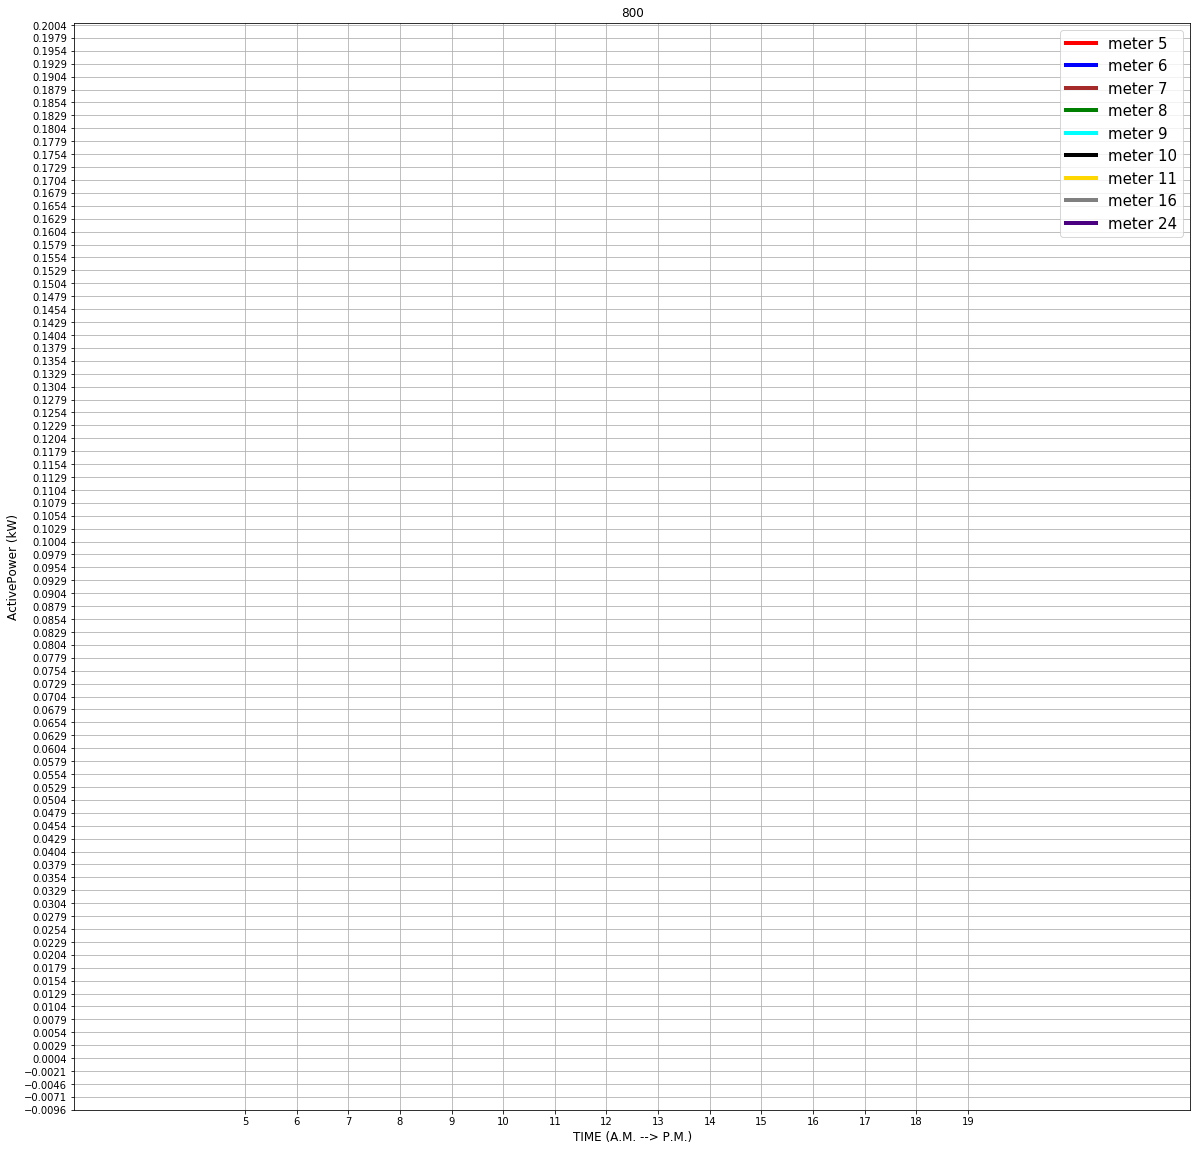

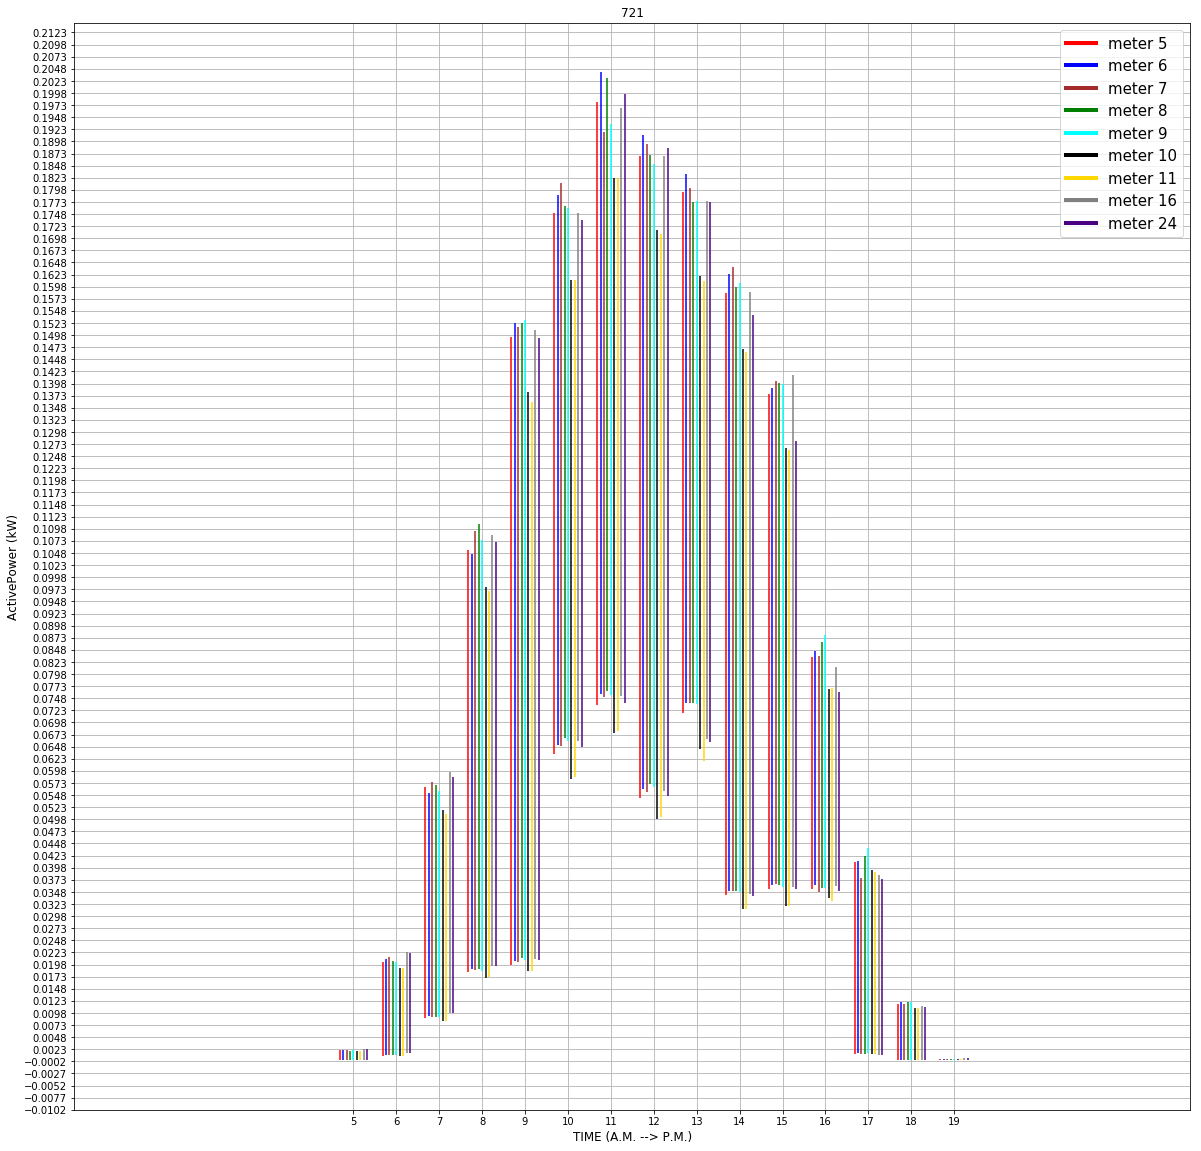

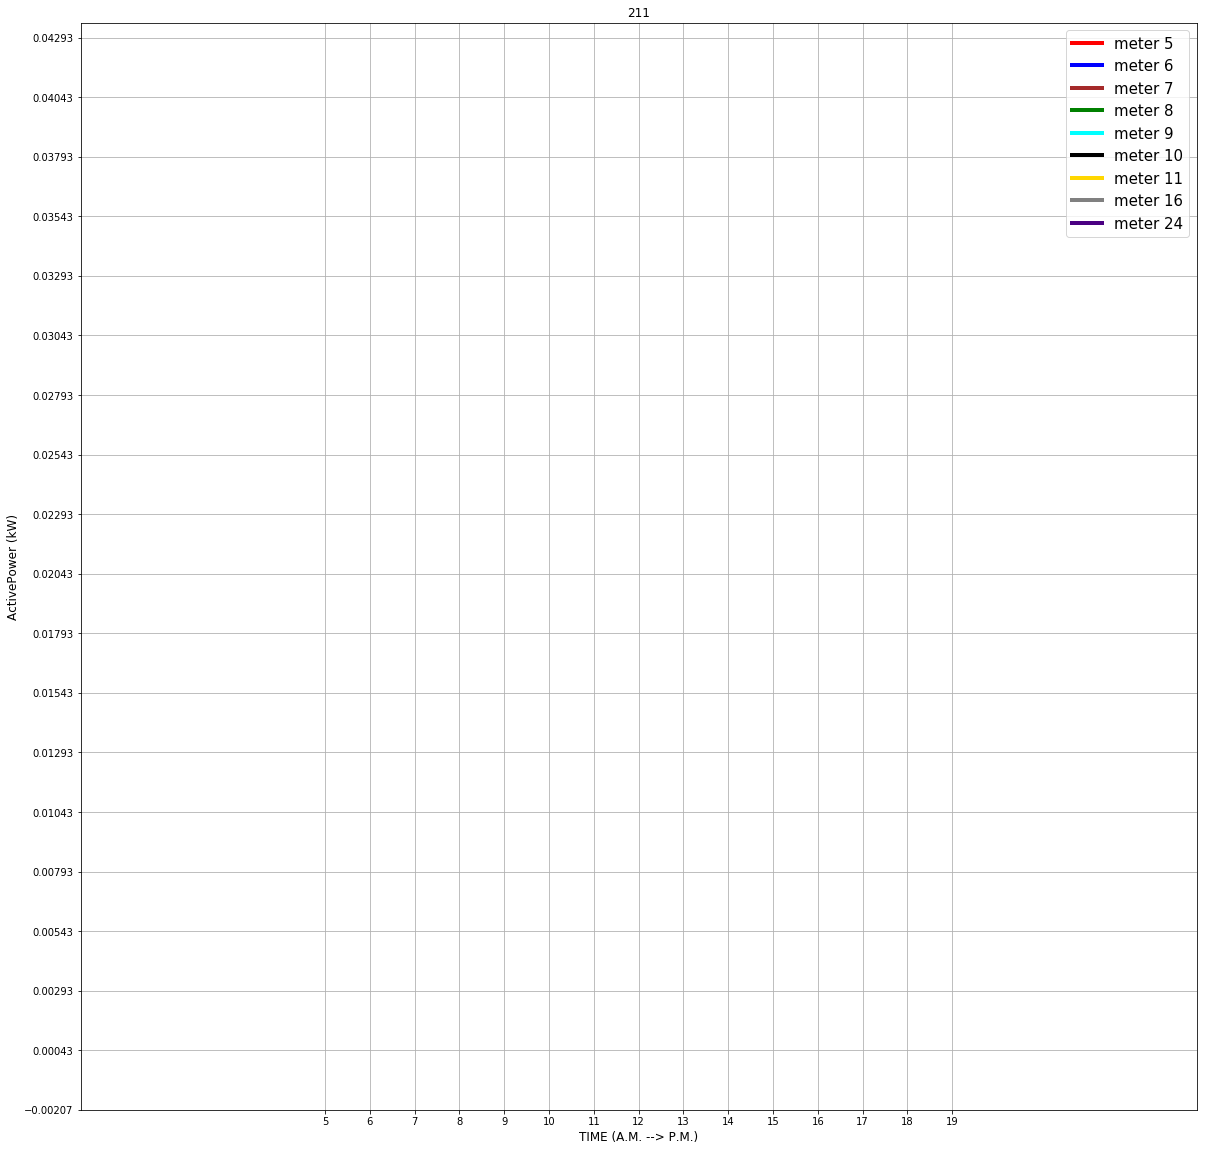

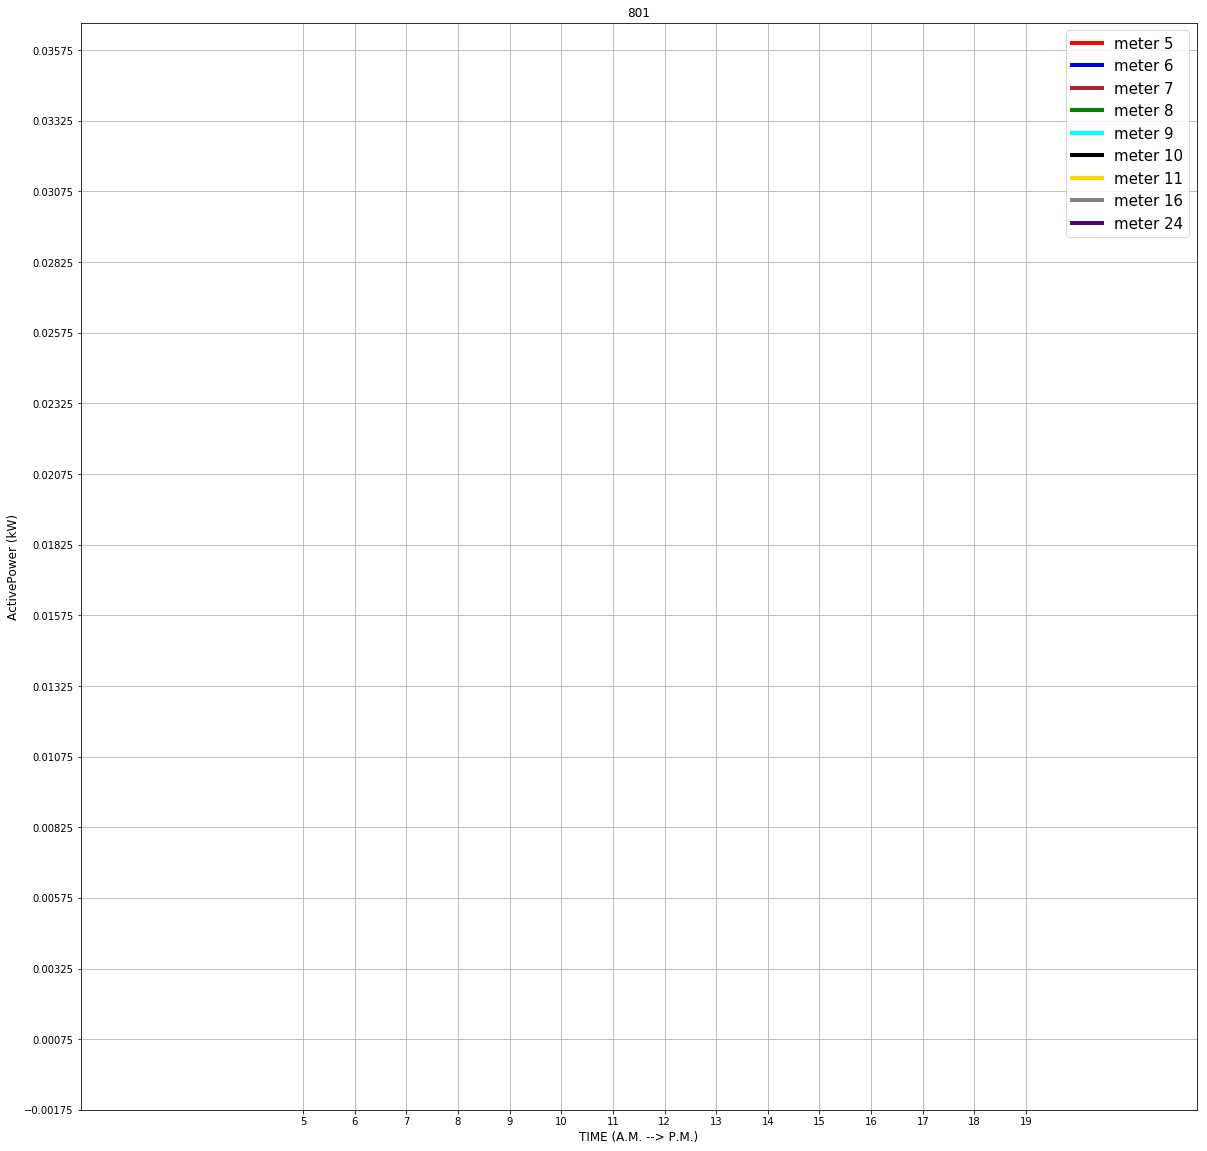

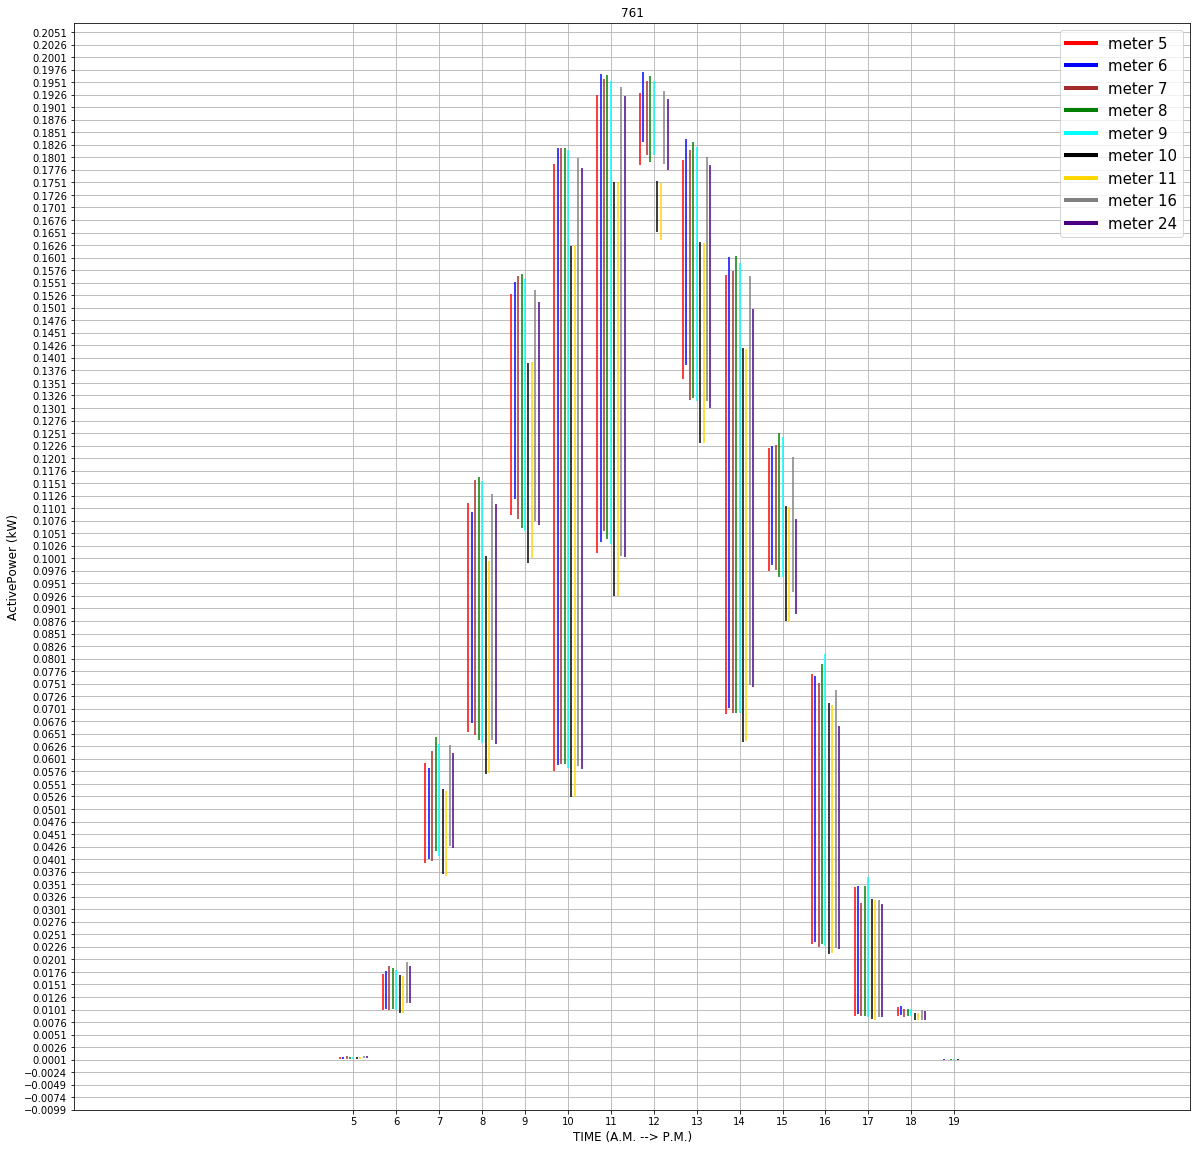

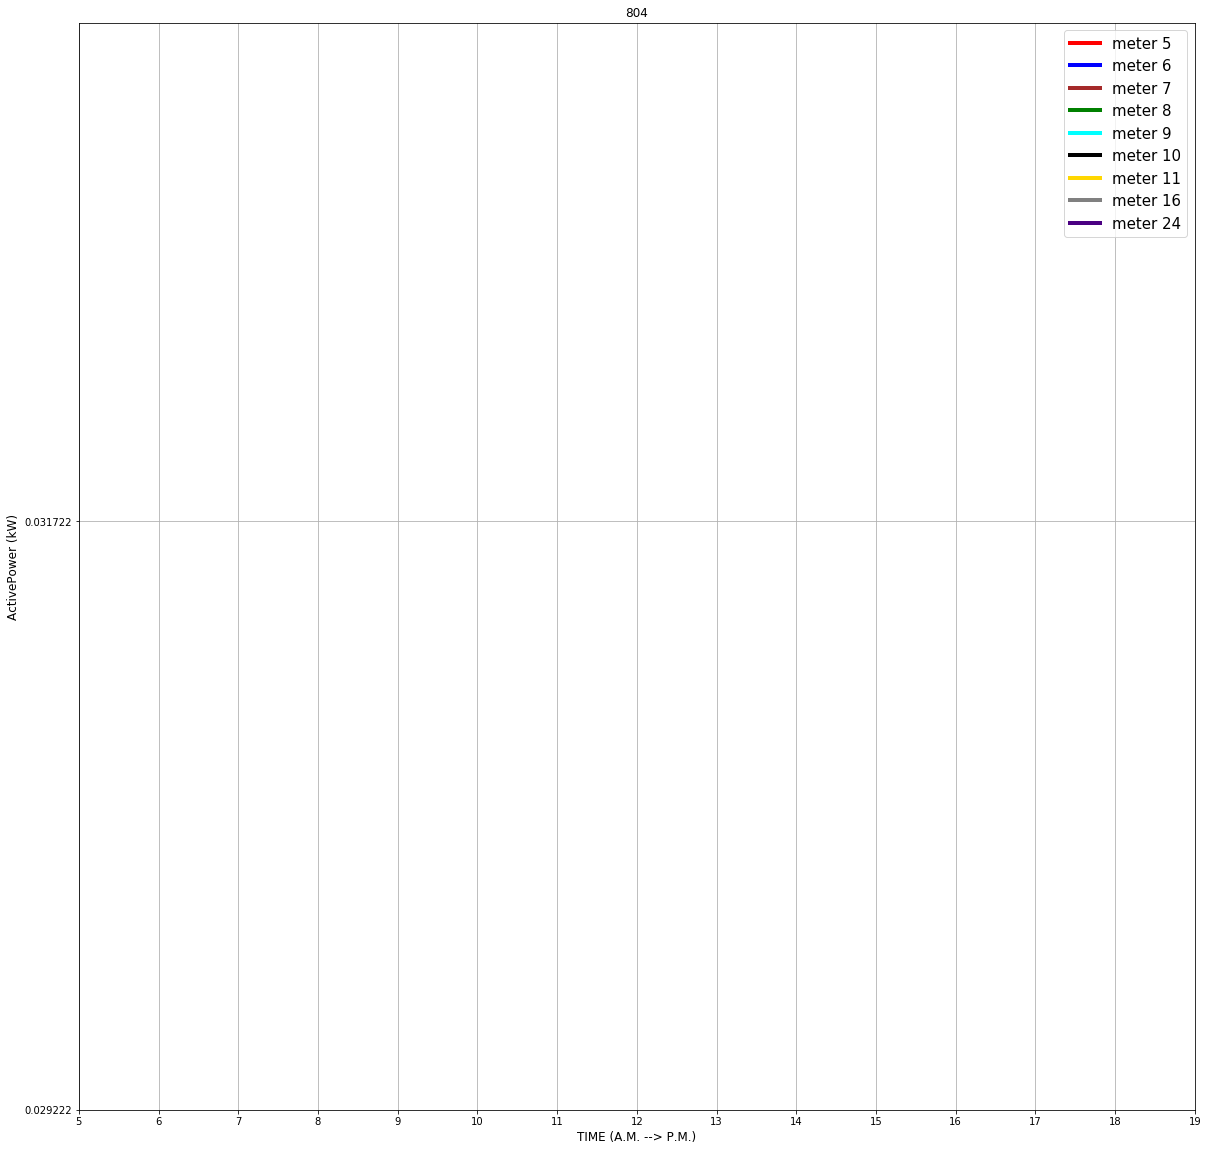

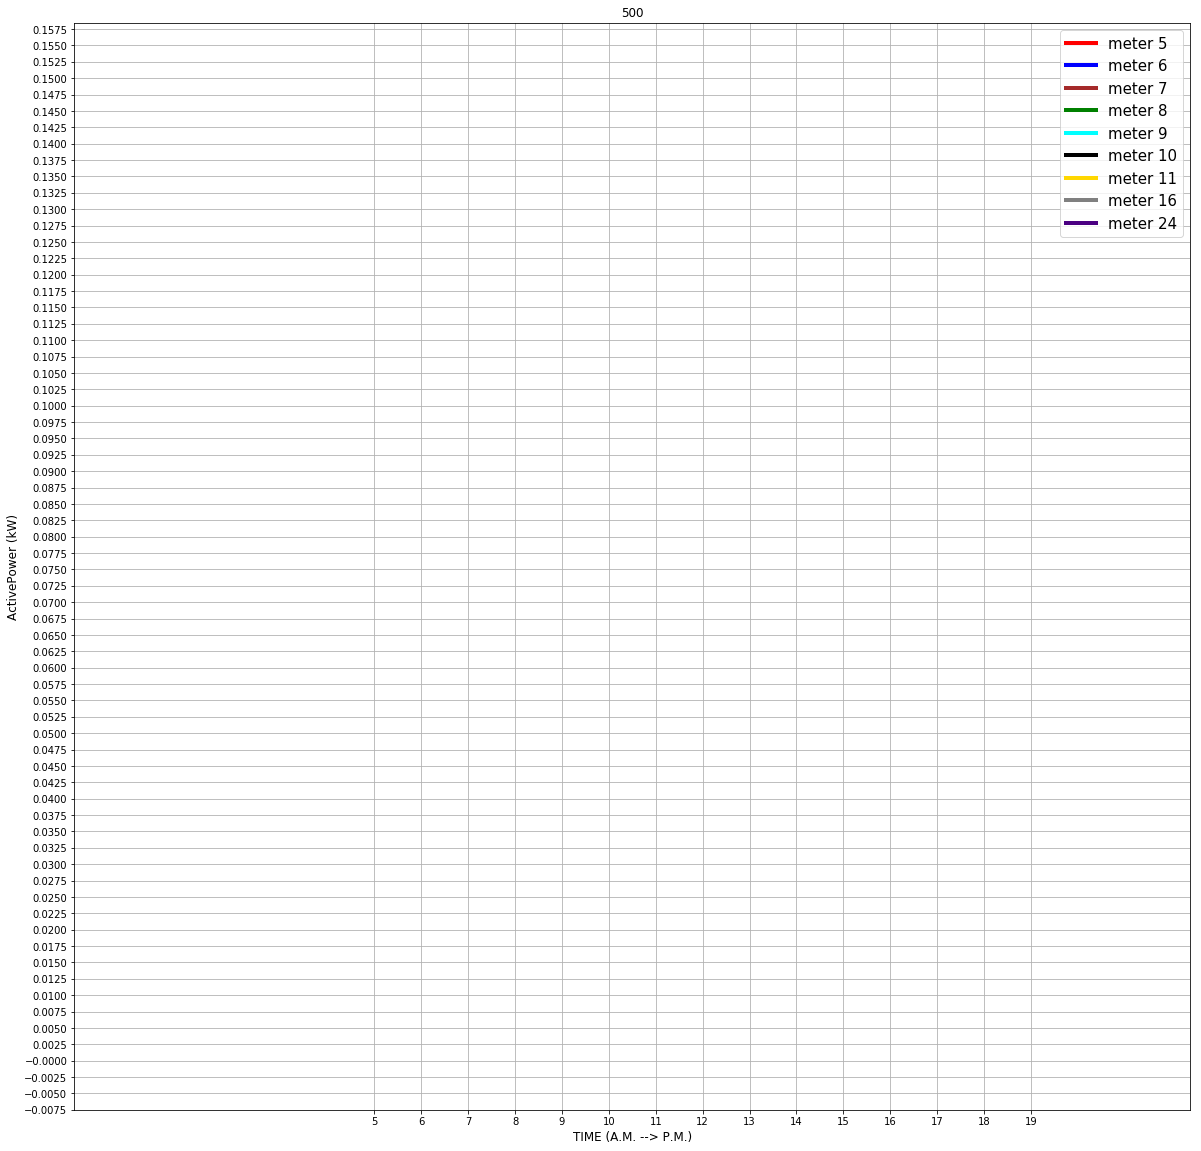

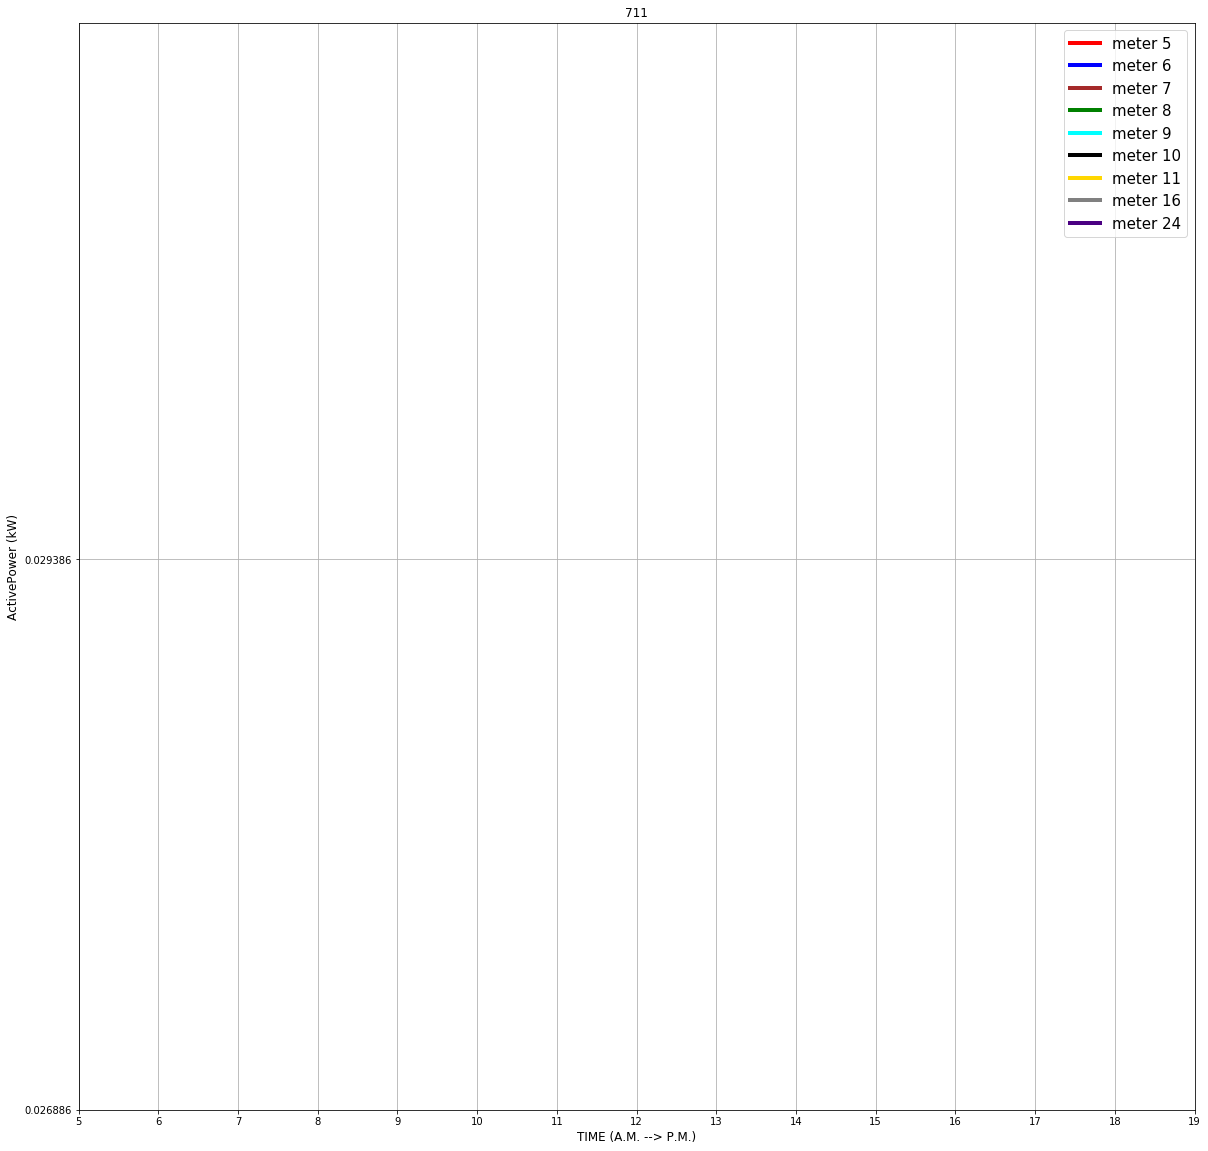

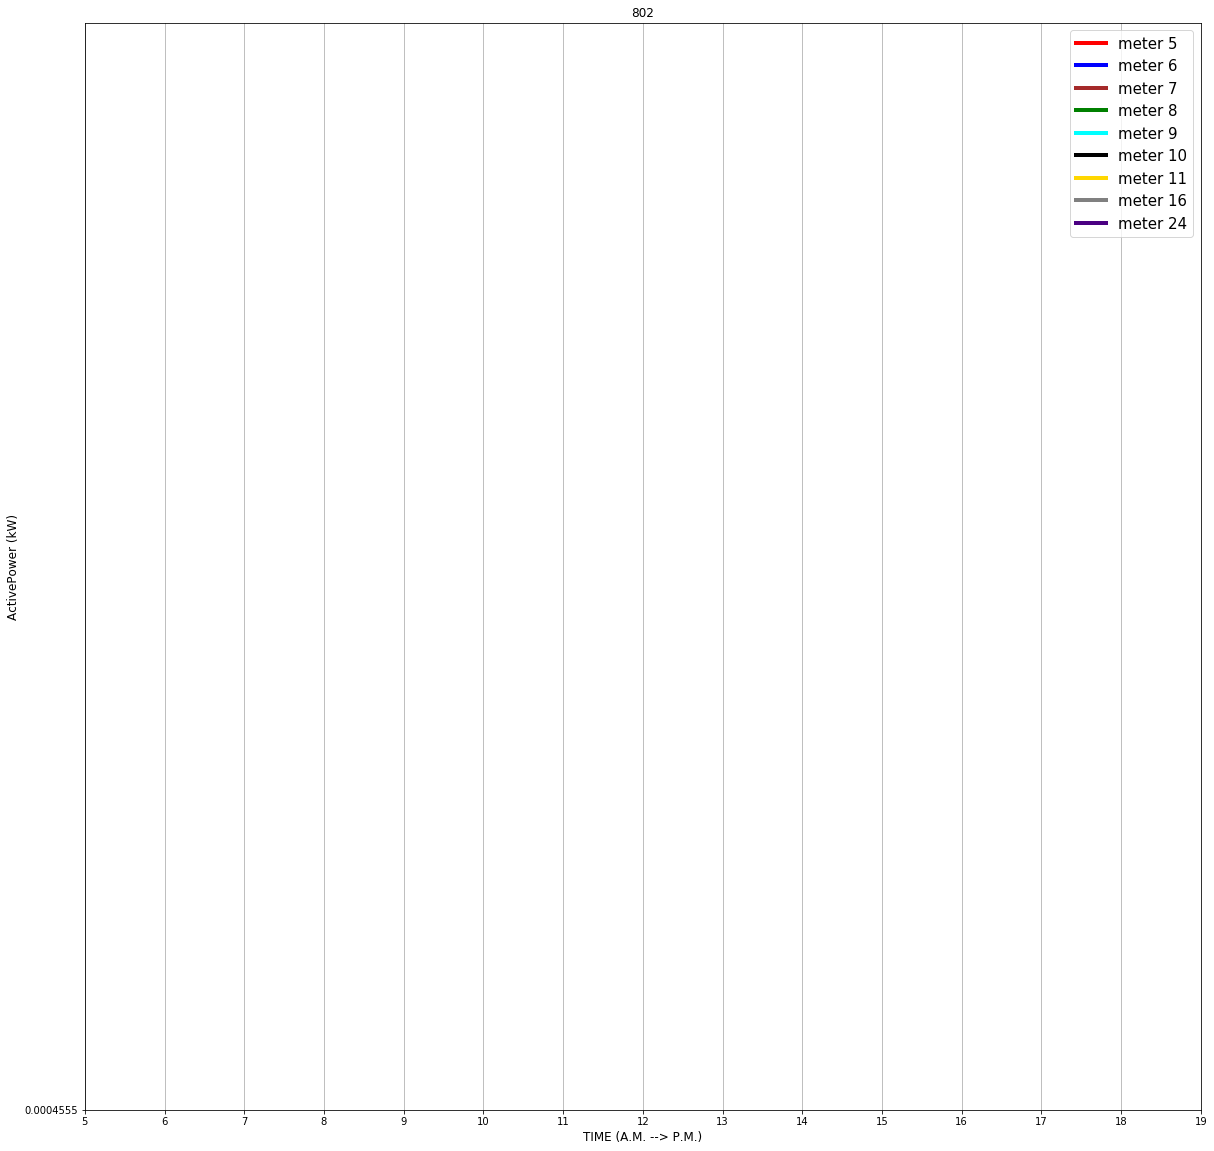

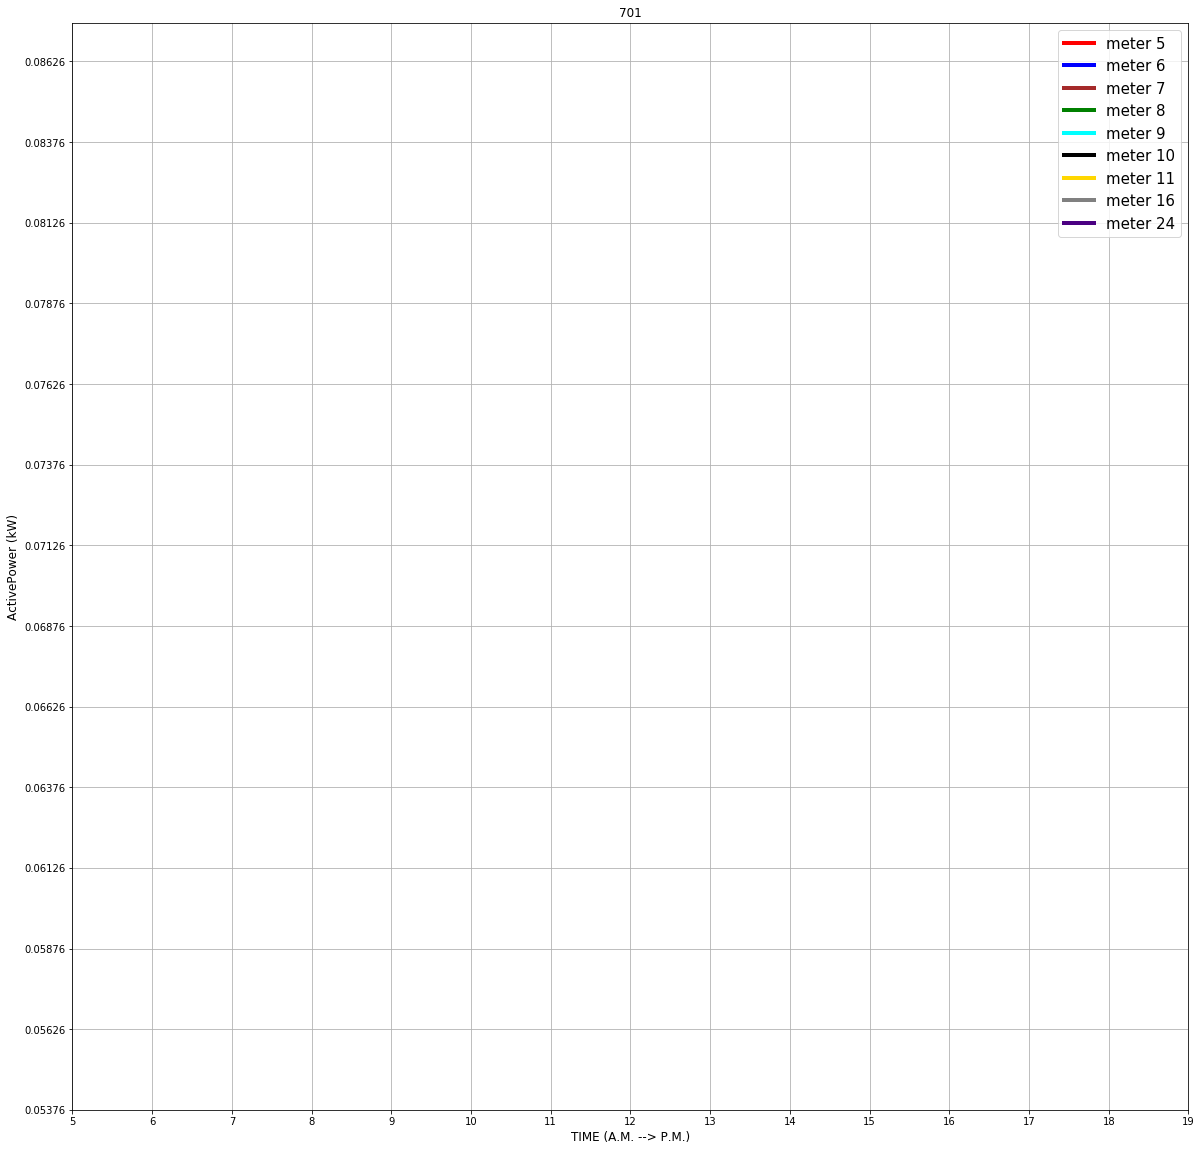

In [73]:
for i in range(len(all_weather_ids)):
    temp = weather_dict[all_weather_ids[i]]
    #print (temp)
    show_plot_max_min_meters(temp, all_weather_ids[i])